In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation
from tdgl.sources import LinearRamp, ConstantField
from typing import Optional, Sequence, Union, Tuple
import pint
from matplotlib.transforms import Affine2D
import matplotlib as mpl
import copy
import cmath
import glob
import shutil
import re


os.environ["OPENBLAS_NUM_THREADS"] = "1"
plt.rcParams["figure.figsize"] = (5, 4)

C:\Users\draid\anaconda3\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
project_name = "J7_antidot"

In [3]:
points_filepath = os.getcwd() + "/extracted_data/extracted_points.h5"
with h5py.File(points_filepath, 'r') as f:
    experimental_data = [tuple(row) for row in f['tuples'][:]]

print("Extracted data loaded from " + points_filepath + "\n")
# print(reconstructed_data)

simulation_ranges = [] #[(N, b_min, b_max), ...]

for vortex_count in range(min([n for n, b, i in experimental_data]), max([n for n, b, i in experimental_data]) + 1):
    # Filter tuples where the first index is the specified value
    b_fields = [b for n, b, i in experimental_data if n == vortex_count]
    # Calculate min and max
    if b_fields:  # Check if the filtered list is not empty
        min_b = min(b_fields)
        max_b = max(b_fields)
        simulation_ranges.append((vortex_count, min_b, max_b))
    else:
        print("No values found for the specified vortex_count.")
        
print("Simulation Ranges: " + str(simulation_ranges))

Extracted data loaded from D:\Documents\0Purdue\Research\Rokhinson Lab\CPR-Extraction/extracted_data/extracted_points.h5

Simulation Ranges: [(-7, -0.014696869, -0.010402508), (-6, -0.014685244, -0.007876414), (-5, -0.013360662, -0.006209192), (-4, -0.011739268, -0.004390404), (-3, -0.0100001525, -0.0024705725), (-2, -0.0083198985, -0.0009549158), (-1, -0.006588727, 0.0009), (0, -0.004806638, 0.002653675), (1, -0.0030245502, 0.00435), (2, -0.001446129, 0.006002), (3, 0.0004509756, 0.0077459016), (4, 0.0021689644, 0.009250375), (5, 0.0039048782, 0.010867205), (6, 0.0055294735, 0.012635471), (7, 0.0072097285, 0.013898519), (8, 0.009093651, 0.014706869)]


In [4]:
def make_video_from_solution(
    solution,
    output_file=None,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                output_file=output_file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            #Return early if just saving to file
            if(output_file!=None):
                return
            video = anim.to_html5_video()
        return HTML(video)

In [5]:
#Extracted from Jian's data from 03/13/2024

jj_length = 260e-9 #m
jj_width = 2000e-9 #m
jj_bz_min = 2e-3 #T
phi0 = 2.067833848e-15 #Wb

jj_flux = phi0
jj_area=jj_flux/jj_bz_min
jj_length_eff = jj_area/jj_width
jj_lambda= (jj_length_eff-jj_length)/2
print("Lambda: " + str(round(jj_lambda*1e9, 2)) + " nm")

electrode_width = 0.3 #um
hole_size = 0.8 #um

junction_length = 0.110 #um, 120 by design, 100-110 in real device.

Lambda: 128.48 nm


In [6]:
length_units = "um"
# Material parameters
xi = 0.2
d = 0.1
big_lambda = 0.3


london_lambda = jj_lambda*1e6 #np.sqrt(d*big_lambda)


layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = electrode_width*2+hole_size
total_length = electrode_width*2+hole_size
hole_size = hole_size

film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    # .difference(right_notch, left_notch)
    .resample(401)
    # .buffer(0)
)


# Holes in the film
square_hole = (
    tdgl.Polygon("square_hole", points=box(hole_size, hole_size))
    .resample(401)
    
)


In [7]:
device = tdgl.Device(
    "antidot",
    layer=layer,
    film=film,
    holes=[square_hole],
    # terminals=[source, drain],
    # probe_points=probe_points,
    # length_units=length_units,
)

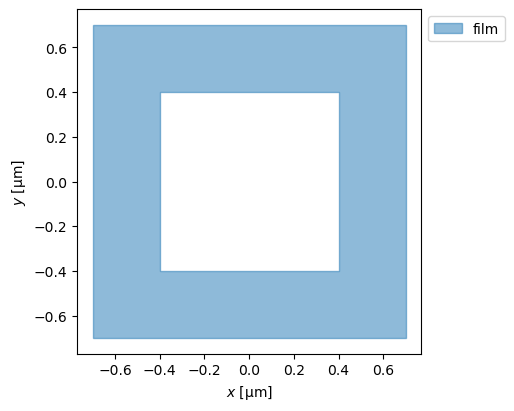

In [8]:
fig, ax = device.draw()

In [9]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|███████████████████████████████████████████████████████████████████████████| 3282/3282 [00:02<00:00, 1441.54it/s]


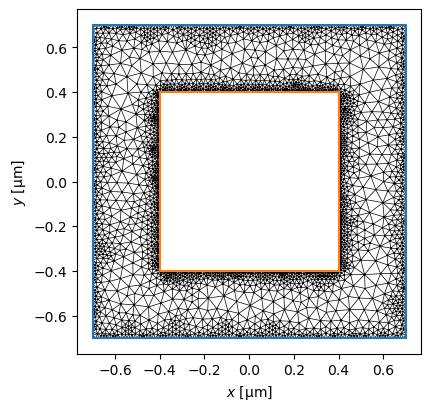

In [10]:
fig, ax = device.plot(mesh=True, legend=False)

In [11]:
# This generates a radially symmetric function for psi using psi(r) and the desired number of vortices.
# It could very easily be replaced to a non-symmetric function
# The other degree of freedom is the mu_boundary that is currently left as zero like the default.
def psi_ansatz(center, vortex_count, psi_radial, points):
    #Note that x, y coordinates and center coordinates must be given in dimensionless coordinates
    x_center = center[0]
    y_center = center[1]
    x = points[:, 0]
    y = points[:, 1]
    phi = np.arctan2((y-y_center),(x-x_center))
    r = np.sqrt((x-x_center)**2 + (y-y_center)**2)
    return np.exp(vortex_count*1j*phi) * psi_radial(r)

def generate_ansatz(device, options, applied_vector_potential, center, vortex_count, psi_radial):
    # This runs a short (time=1) simulation to generate a Solution object easily.
    # This could be done other ways too, but this is short and larger modifications
    # would be better left to the package itself.
    # It then edits the TDGLData object
    
    print("Solving 1 time step to generate most of solution object")
    initial_options = tdgl.SolverOptions(
        solve_time=1,
        field_units = options.field_units,
        current_units = options.current_units,
    )
    solution = tdgl.solve(
        device=device,
        options=initial_options,
    )
    
    print("Calculating Replacement TDGLData")
    
    # Directly create a solver to reuse the ability to calculate mu, super_current, and normal current
    # I would use the one that was used in tdgl.solve but it is not returned. It would be easy to edit
    # the package so that the solver is returned for situations like this. the defaults are copied from
    # Solve.py.  solve_for_observables references some built in properties of the solver: default options, operators, 
    # and mu_boundary. The default options are clearly okay to reference. The operators that are referenced
    # are not changed after they are set during initialization assuming that A remains zero.  This means that the
    # operators are initialized properly for when solver.solve_for_observables is called.
    # solver.mu_boundary is the only parameter that may need to be set, but since no current is flowing into
    # or out of the device, I think it is fair to leave it as it is initialized.  mu_boundary is typically all
    # zero and remains zero when no current is applied.
    
    solver = tdgl.solver.solver.TDGLSolver(
        device=device,
        options=options,
        applied_vector_potential=0,
        terminal_currents=None,
        disorder_epsilon=1,
        seed_solution=None,
    )
    
    new_psi = psi_ansatz(center, vortex_count, psi_radial, solution.device.mesh.sites)
    new_mu, new_supercurrent, new_normal_current = solver.solve_for_observables(psi=new_psi, dA_dt=0)
    
    replacement_data = tdgl.solution.data.TDGLData(
        step=-1,  #Last step
        epsilon=solution.tdgl_data.epsilon, #Leave the same since this is just a physical parameter
        psi=new_psi, #This directly uses the psi_ansatz function defined above
        mu=new_mu, # Calculated using new_psi
        applied_vector_potential=applied_vector_potential, # User Parameter
        induced_vector_potential=np.zeros((len(solution.device.mesh.edge_mesh.edges), 2)), # No screening current, this is zero until a solve step screening is performed  
        supercurrent=new_supercurrent, # Calculated using new_psi
        normal_current=new_normal_current, # Calculated using new_psi
        state=solution.tdgl_data.state, # This should be fine to leave as-is. It just contains {'dt', 'step', 'time', 'timestamp'}
    )
    
    print("Replacing TDGLData")
    solution.tdgl_data = replacement_data
    
    print("Finished Calculating Ansatz")
    return solution
    

In [12]:
#Adjusted constant field that is symmetrical about (0,0) instead of center of mass
def custom_uniform_Bz_vector_potential(
    positions: np.ndarray,
    Bz: Union[float, str, pint.Quantity],
) -> np.ndarray:
    """Calculates the magnetic vector potential [Ax, Ay, Az] at ``positions``
    due uniform magnetic field along the z-axis with strength ``Bz``.

    Args:
        positions: Shape (n, 3) array of (x, y, z) positions in meters at which to
            evaluate the vector potential.
        Bz: The strength of the uniform field, as a pint-parseable string,
            a pint.Quantity, or a float with units of Tesla.

    Returns:
        Shape (n, 3) array of the vector potential [Ax, Ay, Az] at ``positions``
        in units of Tesla * meter.
    """
    ureg = tdgl.em.ureg
    assert isinstance(Bz, (float, str, pint.Quantity)), type(Bz)
    positions = np.atleast_2d(positions)
    assert positions.shape[1] == 3, positions.shape
    if not isinstance(positions, pint.Quantity):
        positions = positions * ureg("meter")
    if isinstance(Bz, str):
        Bz = ureg(Bz)
    if isinstance(Bz, float):
        Bz = Bz * ureg("tesla")
    xs = positions[:, 0]
    ys = positions[:, 1]
    dx = np.ptp(xs)
    dy = np.ptp(ys)
    xs = xs #- (xs.min() + dx / 2)#Do not shift so we can take advantage of symmetry
    ys = ys #- (ys.min() + dy / 2)#Do not shift so we can take advantage of symmetry
    Ax = -Bz * ys / 2
    Ay = Bz * xs / 2
    A = np.stack([Ax, Ay, np.zeros_like(Ax)], axis=1)
    return A.to("tesla * meter")

#Adjusted constant field that is symmetrical about (0,0) instead of center of mass
def custom_constant_field_vector_potential(
    x,
    y,
    z,
    *,
    Bz: float,
    field_units: str = "mT",
    length_units: str = "um",
):
    ureg = tdgl.em.ureg
    if z.ndim == 0:
        z = z * np.ones_like(x)
    positions = np.array([x.squeeze(), y.squeeze(), z.squeeze()]).T
    positions = (positions * ureg(length_units)).to("m").magnitude
    Bz = Bz * ureg(field_units)
    A = custom_uniform_Bz_vector_potential(positions, Bz)
    return A.to(f"{field_units} * {length_units}").magnitude

#Adjusted constant field that is symmetrical about (0,0) instead of center of mass
def custom_ConstantField(
    value: float = 0, field_units: str = "mT", length_units: str = "um"
) -> tdgl.Parameter:
    """Returns a Parameter that computes a constant as a function of ``x, y, z``.
    Args:
        value: The constant value of the field.
    Returns:
        A Parameter that returns ``value`` at all ``x, y, z``.
    """
    return tdgl.Parameter(
        custom_constant_field_vector_potential,
        Bz=float(value),
        field_units=field_units,
        length_units=length_units,
    )

In [13]:
def calculate_solution(field_strength, initial_vortex_count, save_file, seed_solution=None):
    # field_strength = 5
    
    global project_name
#     initial_vortex_count = 0

    options_no_screening = tdgl.SolverOptions(
        solve_time=250,
        field_units = "mT",
        current_units="uA",
        output_file=save_file,
        save_every=800,
        include_screening=False,
    )

    applied_A = custom_ConstantField(field_strength, field_units=options_no_screening.field_units, length_units=device.length_units)
    
    print("Calculating for Field", field_strength)
    try:
        solution = tdgl.Solution.from_hdf5(save_file)
        print("No Screening Solution Already Exists")
    except FileNotFoundError as e:
        print("No Screening Existing solution not found. Solving.")

        if(seed_solution is None):
            seed_solution = generate_ansatz(
                device=device,
                options=options_no_screening,
                applied_vector_potential=applied_A,#Set this to be what you want to test after generating the ansatz
                center=(0,0),
                vortex_count=initial_vortex_count,
                psi_radial= lambda r: 1 - np.exp(-.2*r),
            )
            

        solution = tdgl.solve(
            device,
            options=options_no_screening,
            applied_vector_potential=applied_A,
            seed_solution=seed_solution,
        )
    return solution, applied_A

In [24]:
def recalculate_solution_with_screening(field_strength, initial_vortex_count, seed_solution, save_file):
    global project_name

    options_with_screening = tdgl.SolverOptions(
        solve_time=10,
        field_units = "mT",
        current_units="uA",
        output_file=save_file,
        save_every=800,
        include_screening=True,
    )

    applied_A = custom_ConstantField(field_strength, field_units=options_with_screening.field_units, length_units=device.length_units)
    
    try:
        solution = tdgl.Solution.from_hdf5(save_file)
        print("Screening Solution Already Exists")
    except FileNotFoundError as e:
        print("Screening solution not found. Solving.")

        solution = tdgl.solve(
            device,
            options=options_with_screening,
            applied_vector_potential=applied_A,
            seed_solution=seed_solution,
        )
    return solution, applied_A

In [15]:
def calculate_edge_current(solution, x_list, thickness):

#    # Plot segment
#     fig, axes = plt.subplots(1, 2, figsize=(6, 4))
#     _ = solution.plot_currents(ax=axes[0], streamplot=False)
#     _ = solution.plot_currents(ax=axes[1])

    #Take current through a short segment on the border
    ymin =  -total_length/2-0.001
    ymax = ymin + 0.01
    y = np.linspace(ymin, ymax, 401)
    x = x_list * np.ones_like(y)
    cross_section = np.array([x, y]).T

    current = solution.current_through_path(cross_section)/((ymax-ymin-0.001)*1e-6)/thickness
    return current

def plot_edge_currents(x, currents):
    plt.plot(x, currents)
    plt.title("Edge Current")
    plt.xlabel("X_coordinate [um]")
    plt.ylabel("edge_current_density [A/m^2]")
    plt.show()
    
def plot_currents(solution):
   # Plot segment
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    _ = solution.plot_currents(ax=axes[0], streamplot=False)
    _ = solution.plot_currents(ax=axes[1])
    plt.show()

In [16]:
def calculate_x_phase(x, currents, field_strength):
    global london_lambda, junction_length
    phi0 = 2.067833848e-15 #Wb
    u0 = 1.256637*1e-6 #N*A**(-2)
    eta = (2*np.pi/phi0) * ((london_lambda*1e-6)**2*u0) #Constant in units of m/A
    x_phase = [(-2*eta*current + 2*np.pi*field_strength*(1e-3)*junction_length*1e-6/phi0)*x_i for (current, x_i) in zip(currents, x)]
    return x_phase
    
def plot_x_phase(x, x_phase):
    plt.plot(x, x_phase)
    plt.title("Guage Invariant Phase (Pre-Optimization)")
    plt.ylabel("Phase")
    plt.xlabel("X_coordinate [um]")
    plt.show()
    
def plot_psi(solution, show = True):
    fig, axes = solution.plot_order_parameter(figsize=(5.5, 4))
    if(show):
        plt.show()
        
    return fig, axes

In [19]:
def get_newest_file(directory):
    files = glob.glob(os.path.join(directory, '*'))
    return max(files, key=os.path.getmtime)

def get_vortex_count(solution):
    solution.solve_step = -1
    phases = solution.boundary_phases()["square_hole"].phases
    vortex_count = ((phases[-1]-phases[0])/(2*np.pi))
    return vortex_count

# Calculate New Solutions
simulation_b_count = 20
video_counter = 0
for initial_vortex_count, b_min, b_max in simulation_ranges:
    # Skip some simulations for now.
#     if(initial_vortex_count < -4 or initial_vortex_count > 4):
#         continue
    for field_strength in np.linspace(b_min*1000, b_max*1000, simulation_b_count): #Convert B field to mT
        save_file=os.getcwd() + "/solutions/" + project_name + "/no_screening/" + "field_" + str(field_strength) + "_vortex_" + str(initial_vortex_count) + ".h5"
        calculate_solution(field_strength, initial_vortex_count, save_file)
        solution = tdgl.Solution.from_hdf5(save_file)
        if(video_counter%5==0):
            solution_name = get_newest_file(os.getcwd() + "/solutions/" + project_name + "/no_screening/").split("\\")[-1]
            try:
                #Generate the video if it doesn't exit
                video_filename = os.getcwd() + "/videos/" + project_name + "/no_screening/" + solution_name[:-3] + ".mp4"
                if not(os.path.exists(video_filename)):
                    pass
#                     make_video_from_solution(solution, output_file=video_filename)
            except FileNotFoundError as e:
                print("Error Loading Solution: " + solution)
                print(e)
           
        # Check to see if solution still contains the same number of vortices. If it does, it is a good screening solution
        # so move it to the stable_no_screening folder
        final_vortex_count = get_vortex_count(solution)
        if(round(final_vortex_count) == initial_vortex_count):
            print("MATCH\n")
            destination_file = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/" + "field_" + str(field_strength) + "_vortex_" + str(initial_vortex_count) + ".h5"
            shutil.copy(save_file, destination_file)
        else:
            print("     MISMATCH\n")
        video_counter += 1


Calculating for Field -14.696869067847729
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.42tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:00<00:00,  2.07tau/s ]


MATCH

Calculating for Field -14.47085006848762
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.95tau/s ]


MATCH

Calculating for Field -14.244831069127509
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:05<00:00,  1.99tau/s ]


MATCH

Calculating for Field -14.0188120697674
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:07<00:00,  1.96tau/s ]


MATCH

Calculating for Field -13.79279307040729
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.74tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:06<00:00,  1.98tau/s ]


MATCH

Calculating for Field -13.566774071047181
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.13tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.94tau/s ]


MATCH

Calculating for Field -13.34075507168707
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.35tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.94tau/s ]


MATCH

Calculating for Field -13.114736072326961
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.70tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:11<00:00,  1.90tau/s ]


MATCH

Calculating for Field -12.888717072966852
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.21tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:14<00:00,  1.86tau/s ]


MATCH

Calculating for Field -12.662698073606741
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.89tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:11<00:00,  1.91tau/s ]


MATCH

Calculating for Field -12.436679074246632
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.39tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:10<00:00,  1.91tau/s ]


MATCH

Calculating for Field -12.210660074886523
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.69tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:11<00:00,  1.89tau/s ]


MATCH

Calculating for Field -11.984641075526413
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.85tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:12<00:00,  1.88tau/s ]


MATCH

Calculating for Field -11.758622076166304
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.94tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:11<00:00,  1.90tau/s ]


MATCH

Calculating for Field -11.532603076806193
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.84tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:10<00:00,  1.91tau/s ]


MATCH

Calculating for Field -11.306584077446084
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.46tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:11<00:00,  1.90tau/s ]


MATCH

Calculating for Field -11.080565078085975
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.99tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.93tau/s ]


MATCH

Calculating for Field -10.854546078725864
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.87tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:10<00:00,  1.91tau/s ]


MATCH

Calculating for Field -10.628527079365755
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.10tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.94tau/s ]


MATCH

Calculating for Field -10.402508080005646
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.44tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.93tau/s ]


MATCH

Calculating for Field -14.685244299471378
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.01tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:03<00:00,  2.03tau/s ]


     MISMATCH

Calculating for Field -14.326884803411208
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.69tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:05<00:00,  1.99tau/s ]


     MISMATCH

Calculating for Field -13.968525307351037
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.18tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.94tau/s ]


     MISMATCH

Calculating for Field -13.610165811290866
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.94tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.93tau/s ]


     MISMATCH

Calculating for Field -13.251806315230695
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.85tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:07<00:00,  1.96tau/s ]


MATCH

Calculating for Field -12.893446819170524
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.03tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.95tau/s ]


MATCH

Calculating for Field -12.535087323110353
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.80tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:13<00:00,  1.87tau/s ]


MATCH

Calculating for Field -12.176727827050184
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.97tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:15<00:00,  1.84tau/s ]


MATCH

Calculating for Field -11.818368330990014
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.88tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:18<00:00,  1.81tau/s ]


MATCH

Calculating for Field -11.460008834929843
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:22<00:00,  1.75tau/s ]


MATCH

Calculating for Field -11.101649338869672
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.23tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:19<00:00,  1.80tau/s ]


MATCH

Calculating for Field -10.743289842809501
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.94tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:19<00:00,  1.79tau/s ]


MATCH

Calculating for Field -10.38493034674933
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.84tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:20<00:00,  1.78tau/s ]


MATCH

Calculating for Field -10.02657085068916
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:18<00:00,  1.80tau/s ]


MATCH

Calculating for Field -9.66821135462899
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.53tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:17<00:00,  1.82tau/s ]


MATCH

Calculating for Field -9.30985185856882
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.59tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:18<00:00,  1.81tau/s ]


MATCH

Calculating for Field -8.951492362508649
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.16tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:13<00:00,  1.87tau/s ]


MATCH

Calculating for Field -8.593132866448478
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.84tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:26<00:00,  1.71tau/s ]


MATCH

Calculating for Field -8.234773370388307
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.41tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:26<00:00,  1.71tau/s ]


MATCH

Calculating for Field -7.8764138743281364
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:25<00:00,  1.72tau/s ]


MATCH

Calculating for Field -13.360662385821342
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.54tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:17<00:00,  1.82tau/s ]


     MISMATCH

Calculating for Field -12.984269200579115
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:25<00:00,  1.72tau/s ]


     MISMATCH

Calculating for Field -12.60787601533689
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.38tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:17<00:00,  1.82tau/s ]


     MISMATCH

Calculating for Field -12.231482830094663
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.46tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:19<00:00,  1.79tau/s ]


     MISMATCH

Calculating for Field -11.855089644852438
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.12tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:24<00:00,  1.73tau/s ]


     MISMATCH

Calculating for Field -11.47869645961021
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.45tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:25<00:00,  1.72tau/s ]


MATCH

Calculating for Field -11.102303274367985
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.57tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:40<00:00,  1.56tau/s ]


MATCH

Calculating for Field -10.725910089125758
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.67tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:45<00:00,  1.51tau/s ]


MATCH

Calculating for Field -10.349516903883533
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.50tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:38<00:00,  1.58tau/s ]


MATCH

Calculating for Field -9.973123718641306
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.36tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:42<00:00,  1.54tau/s ]


MATCH

Calculating for Field -9.59673053339908
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.56tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:44<00:00,  1.52tau/s ]


MATCH

Calculating for Field -9.220337348156853
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.11tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:46<00:00,  1.50tau/s ]


MATCH

Calculating for Field -8.843944162914628
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.97tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:41<00:00,  1.55tau/s ]


MATCH

Calculating for Field -8.467550977672401
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:40<00:00,  1.55tau/s ]


MATCH

Calculating for Field -8.091157792430174
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.57tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:40<00:00,  1.56tau/s ]


MATCH

Calculating for Field -7.7147646071879485
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.18tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:42<00:00,  1.53tau/s ]


MATCH

Calculating for Field -7.338371421945722
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.32tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:37<00:00,  1.59tau/s ]


MATCH

Calculating for Field -6.961978236703496
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.68tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:30<00:00,  1.66tau/s ]


MATCH

Calculating for Field -6.58558505146127
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.71tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:20<00:00,  1.77tau/s ]


MATCH

Calculating for Field -6.209191866219044
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.04tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:18<00:00,  1.81tau/s ]


MATCH

Calculating for Field -11.739267967641354
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -11.352485658502893
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -10.965703349364432
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -10.57892104022597
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -10.192138731087509
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -9.805356421949048
No Screening Solution Already Exists
MATCH

Calculating for Field -9.418574112810587
No Screening Solution Already Exists
MATCH

Calculating for Field -9.031791803672125
No Screening Solution Already Exists
MATCH

Calculating for Field -8.645009494533664
No Screening Solution Already Exists
MATCH

Calculating for Field -8.258227185395203
No Screening Solution Already Exists
MATCH

Calculating for Field -7.871444876256742
No Screening Solution Already Exists
MATCH

Calculating fo

Calculating for Field 0.6904346182158116
No Screening Solution Already Exists
MATCH

Calculating for Field 1.0830826787768224
No Screening Solution Already Exists
MATCH

Calculating for Field 1.4757307393378332
No Screening Solution Already Exists
MATCH

Calculating for Field 1.868378799898844
No Screening Solution Already Exists
MATCH

Calculating for Field 2.2610268604598547
No Screening Solution Already Exists
MATCH

Calculating for Field 2.6536749210208654
No Screening Solution Already Exists
MATCH

Calculating for Field -3.0245501548051834
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -2.6364159329157126
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -2.248281711026242
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -1.860147489136771
No Screening Solution Already Exists
     MISMATCH

Calculating for Field -1.4720132672473003
No Screening Solution Already Exists
MATCH

Calculating for Field -1.083879

Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.41tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:33<00:00,  1.63tau/s ]


     MISMATCH

Calculating for Field 4.271316440089753
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.38tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:35<00:00,  1.61tau/s ]


     MISMATCH

Calculating for Field 4.637754718331914
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.50tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:22<00:00,  1.75tau/s ]


     MISMATCH

Calculating for Field 5.0041929965740755
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.86tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:24<00:00,  1.74tau/s ]


     MISMATCH

Calculating for Field 5.370631274816237
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.47tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:19<00:00,  1.80tau/s ]


     MISMATCH

Calculating for Field 5.737069553058398
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.07tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:15<00:00,  1.84tau/s ]


MATCH

Calculating for Field 6.1035078313005595
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:16<00:00,  1.83tau/s ]


MATCH

Calculating for Field 6.469946109542722
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.22tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:23<00:00,  1.74tau/s ]


MATCH

Calculating for Field 6.836384387784882
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.41tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:21<00:00,  1.77tau/s ]


MATCH

Calculating for Field 7.2028226660270445
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.66tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:20<00:00,  1.78tau/s ]


MATCH

Calculating for Field 7.569260944269205
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.66tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:22<00:00,  1.76tau/s ]


MATCH

Calculating for Field 7.935699222511367
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.94tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:24<00:00,  1.73tau/s ]


MATCH

Calculating for Field 8.302137500753528
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.84tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:24<00:00,  1.73tau/s ]


MATCH

Calculating for Field 8.66857577899569
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:27<00:00,  1.70tau/s ]


MATCH

Calculating for Field 9.035014057237852
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.59tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:26<00:00,  1.70tau/s ]


MATCH

Calculating for Field 9.401452335480013
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.60tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:26<00:00,  1.70tau/s ]


MATCH

Calculating for Field 9.767890613722173
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:24<00:00,  1.73tau/s ]


MATCH

Calculating for Field 10.134328891964335
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.90tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:33<00:00,  1.63tau/s ]


MATCH

Calculating for Field 10.500767170206498
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:28<00:00,  1.68tau/s ]


MATCH

Calculating for Field 10.867205448448658
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:23<00:00,  1.74tau/s ]


MATCH

Calculating for Field 5.529473535716534
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.70tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:34<00:00,  1.61tau/s ]


     MISMATCH

Calculating for Field 5.903473418009908
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:35<00:00,  1.61tau/s ]


     MISMATCH

Calculating for Field 6.277473300303283
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.99tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:27<00:00,  1.69tau/s ]


     MISMATCH

Calculating for Field 6.651473182596659
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:20<00:00,  1.78tau/s ]


     MISMATCH

Calculating for Field 7.025473064890034
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:28<00:00,  1.68tau/s ]


     MISMATCH

Calculating for Field 7.399472947183408
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:10<00:00,  1.91tau/s ]


MATCH

Calculating for Field 7.773472829476783
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.93tau/s ]


MATCH

Calculating for Field 8.147472711770158
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.74tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:12<00:00,  1.89tau/s ]


MATCH

Calculating for Field 8.521472594063534
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:14<00:00,  1.86tau/s ]


MATCH

Calculating for Field 8.895472476356908
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:15<00:00,  1.84tau/s ]


MATCH

Calculating for Field 9.269472358650283
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:21<00:00,  1.77tau/s ]


MATCH

Calculating for Field 9.643472240943659
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:19<00:00,  1.79tau/s ]


MATCH

Calculating for Field 10.017472123237033
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:31<00:00,  1.65tau/s ]


MATCH

Calculating for Field 10.391472005530407
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:24<00:00,  1.73tau/s ]


MATCH

Calculating for Field 10.765471887823782
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.98tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:30<00:00,  1.66tau/s ]


MATCH

Calculating for Field 11.139471770117158
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.80tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:23<00:00,  1.75tau/s ]


MATCH

Calculating for Field 11.513471652410534
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.74tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:24<00:00,  1.73tau/s ]


MATCH

Calculating for Field 11.887471534703907
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:22<00:00,  1.75tau/s ]


MATCH

Calculating for Field 12.261471416997281
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:18<00:00,  1.81tau/s ]


MATCH

Calculating for Field 12.635471299290657
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.78tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:17<00:00,  1.82tau/s ]


MATCH

Calculating for Field 7.209728471934795
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:29<00:00,  1.67tau/s ]


     MISMATCH

Calculating for Field 7.561770071716685
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:28<00:00,  1.68tau/s ]


     MISMATCH

Calculating for Field 7.913811671498575
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:28<00:00,  1.68tau/s ]


     MISMATCH

Calculating for Field 8.265853271280465
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.11tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:17<00:00,  1.82tau/s ]


     MISMATCH

Calculating for Field 8.617894871062354
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.06tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:25<00:00,  1.72tau/s ]


     MISMATCH

Calculating for Field 8.969936470844244
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.77tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:23<00:00,  1.74tau/s ]


     MISMATCH

Calculating for Field 9.321978070626134
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.30tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:07<00:00,  1.96tau/s ]


MATCH

Calculating for Field 9.674019670408022
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:10<00:00,  1.92tau/s ]


MATCH

Calculating for Field 10.026061270189913
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.63tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:12<00:00,  1.89tau/s ]


MATCH

Calculating for Field 10.378102869971801
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:10<00:00,  1.91tau/s ]


MATCH

Calculating for Field 10.730144469753693
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.88tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:15<00:00,  1.85tau/s ]


MATCH

Calculating for Field 11.082186069535581
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:12<00:00,  1.89tau/s ]


MATCH

Calculating for Field 11.43422766931747
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:12<00:00,  1.89tau/s ]


MATCH

Calculating for Field 11.78626926909936
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.97tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:27<00:00,  1.70tau/s ]


MATCH

Calculating for Field 12.13831086888125
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.20tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:21<00:00,  1.77tau/s ]


MATCH

Calculating for Field 12.49035246866314
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:16<00:00,  1.84tau/s ]


MATCH

Calculating for Field 12.84239406844503
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.31tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:16<00:00,  1.83tau/s ]


MATCH

Calculating for Field 13.19443566822692
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.66tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:16<00:00,  1.84tau/s ]


MATCH

Calculating for Field 13.54647726800881
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.27tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:15<00:00,  1.85tau/s ]


MATCH

Calculating for Field 13.898518867790699
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.48tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.93tau/s ]


MATCH

Calculating for Field 9.093650616705418
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.84tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:30<00:00,  1.66tau/s ]


     MISMATCH

Calculating for Field 9.389083146264678
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:26<00:00,  1.70tau/s ]


     MISMATCH

Calculating for Field 9.68451567582394
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:20<00:00,  1.78tau/s ]


     MISMATCH

Calculating for Field 9.9799482053832
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.13tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.95tau/s ]


     MISMATCH

Calculating for Field 10.27538073494246
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:11<00:00,  1.90tau/s ]


     MISMATCH

Calculating for Field 10.570813264501723
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.94tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.93tau/s ]


     MISMATCH

Calculating for Field 10.866245794060983
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:11<00:00,  1.89tau/s ]


     MISMATCH

Calculating for Field 11.161678323620244
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.73tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:05<00:00,  1.99tau/s ]


MATCH

Calculating for Field 11.457110853179504
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:01<00:00,  2.06tau/s ]


MATCH

Calculating for Field 11.752543382738766
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.06tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:02<00:00,  2.03tau/s ]


MATCH

Calculating for Field 12.047975912298027
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.89tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.94tau/s ]


MATCH

Calculating for Field 12.343408441857289
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:05<00:00,  2.00tau/s ]


MATCH

Calculating for Field 12.638840971416549
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:09<00:00,  1.93tau/s ]


MATCH

Calculating for Field 12.93427350097581
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.16tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:15<00:00,  1.85tau/s ]


MATCH

Calculating for Field 13.22970603053507
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.19tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:18<00:00,  1.81tau/s ]


MATCH

Calculating for Field 13.52513856009433
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.19tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:18<00:00,  1.81tau/s ]


MATCH

Calculating for Field 13.820571089653592
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  5.45tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:08<00:00,  1.94tau/s ]


MATCH

Calculating for Field 14.116003619212854
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:10<00:00,  1.91tau/s ]


MATCH

Calculating for Field 14.411436148772115
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  6.64tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:07<00:00,  1.97tau/s ]


MATCH

Calculating for Field 14.706868678331375
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1/1 [00:00<00:00,  7.17tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:06<00:00,  1.97tau/s ]


MATCH



In [55]:
def get_closest_solution(target_field_strength, target_vortex_count, folder):
    try:
        pattern = r'field_([-+]?\d*\.\d+|\d+)_vortex_([-+]?\d+)'
        single_vortex_files = [
            file for file in os.listdir(folder)
            if (match := re.search(pattern, file)) and int(match.group(2)) == target_vortex_count
        ]
        field_strengths = [
            float(re.search(pattern, file).group(1)) for file in single_vortex_files
        ]

        closest_index = np.argmin(np.abs(np.array(field_strengths) - target_field_strength))

        # Get the corresponding filename
        closest_file = single_vortex_files[closest_index]
        closest_float = field_strengths[closest_index]

        # Print the file with the smallest float value
        print(f'File with the closest field: {closest_file}')
        print(f'Closest field value: {closest_file}')
        return closest_file
    except Exception as e:
        return None 
    
# # Redo the simulations that jumped using the closest calculated solution
no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"
stable_no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"
screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"

no_screening_files = os.listdir(no_screening_folder)
stable_no_screening_files = os.listdir(stable_no_screening_folder)

simulation_points = []
for file_name in no_screening_files:
    file_pattern = r'field_([-+]?\d*\.\d+|\d+)_vortex_([-+]?\d+)'
    match = re.search(file_pattern, file_name)
    if match:
        field_strength = float(match.group(1))
        initial_vortex_count = int(match.group(2))
        simulation_points.append((file_name, field_strength, initial_vortex_count))
    else:
        print("WARNING: Corrupt filenames present in ./solutions/no_screening")

for vortex_count_to_simulate in np.unique([point[2] for point in simulation_points]):
    
    #Sort the required simulations by absolute value
    single_vortex_list = sorted([point for point in simulation_points if point[2] == vortex_count_to_simulate], key=lambda point: abs(point[1]))
    for sim_point in single_vortex_list:
        file_name = sim_point[0]
        field_strength = sim_point[1]
        initial_vortex_count = sim_point[2]

        #Determine the seed solution. If a screening solution has been generated, start with that one.
        # Its probably close. Otherwise, use the no_screening_solution
        screening_folder    = os.getcwd() + "/solutions/" + project_name + "/screening/"
        stable_screening_folder    = os.getcwd() + "/solutions/" + project_name + "/stable_screening/"
        stable_no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"
        seed_sol_file_name = get_closest_solution(field_strength, initial_vortex_count, stable_screening_folder)
        if(seed_sol_file_name is None):
            print("Using non_screened seed solution")
            seed_sol_file_name = get_closest_solution(field_strength, initial_vortex_count, stable_no_screening_folder)
            seed_solution = tdgl.Solution.from_hdf5(stable_no_screening_folder + seed_sol_file_name)
        else:
            print("Using screened seed solution")
            seed_solution = tdgl.Solution.from_hdf5(stable_screening_folder + seed_sol_file_name)


        print(f"Calculating {field_strength}, {initial_vortex_count} using {seed_sol_file_name}")
        save_file=screening_folder + file_name

        try:
            recalculate_solution_with_screening(field_strength, initial_vortex_count, seed_solution, save_file)
            solution = tdgl.Solution.from_hdf5(save_file)
            # Check to see if solution still contains the same number of vortices. If it does, it is a good screening solution
            # so move it to the stable_no_screening folder
            final_vortex_count = get_vortex_count(solution)
            if(round(final_vortex_count) == initial_vortex_count):
                print("MATCH", final_vortex_count, initial_vortex_count, "\n")
                destination_file = stable_screening_folder + file_name
                shutil.copy(save_file, destination_file)
            else:
                print("     MISMATCH", final_vortex_count, initial_vortex_count, "\n")
        except Exception as e:
                print(e)
  

File with the closest field: field_-10.402508080005646_vortex_-7.h5
Closest field value: field_-10.402508080005646_vortex_-7.h5
Using screened seed solution
Calculating -10.402508080005646, -7 using field_-10.402508080005646_vortex_-7.h5
Screening Solution Already Exists
MATCH -6.970269462165255 -7 

File with the closest field: field_-10.402508080005646_vortex_-7.h5
Closest field value: field_-10.402508080005646_vortex_-7.h5
Using screened seed solution
Calculating -10.628527079365755, -7 using field_-10.402508080005646_vortex_-7.h5
"Unable to open object (object 'solution' doesn't exist)"
File with the closest field: field_-10.854546078725864_vortex_-7.h5
Closest field value: field_-10.854546078725864_vortex_-7.h5
Using screened seed solution
Calculating -10.854546078725864, -7 using field_-10.854546078725864_vortex_-7.h5
Screening Solution Already Exists
MATCH -6.971046073738439 -7 

File with the closest field: field_-11.080565078085975_vortex_-7.h5
Closest field value: field_-11.0

Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [36:05<00:02, 216.77s/tau ]


MATCH -6.973768228435024 -7 

File with the closest field: field_-12.662698073606741_vortex_-7.h5
Closest field value: field_-12.662698073606741_vortex_-7.h5
Using screened seed solution
Calculating -12.888717072966852, -7 using field_-12.662698073606741_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [46:07<00:02, 276.97s/tau ]


MATCH -6.974075053127796 -7 

File with the closest field: field_-12.888717072966852_vortex_-7.h5
Closest field value: field_-12.888717072966852_vortex_-7.h5
Using screened seed solution
Calculating -13.114736072326961, -7 using field_-12.888717072966852_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [44:39<00:01, 268.08s/tau ]


MATCH -6.974374952817387 -7 

File with the closest field: field_-13.114736072326961_vortex_-7.h5
Closest field value: field_-13.114736072326961_vortex_-7.h5
Using screened seed solution
Calculating -13.34075507168707, -7 using field_-13.114736072326961_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [44:02<00:05, 264.81s/tau ]


MATCH -6.974671107457828 -7 

File with the closest field: field_-13.34075507168707_vortex_-7.h5
Closest field value: field_-13.34075507168707_vortex_-7.h5
Using screened seed solution
Calculating -13.566774071047181, -7 using field_-13.34075507168707_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [24:31<00:02, 147.42s/tau ]


MATCH -6.974962502130603 -7 

File with the closest field: field_-13.566774071047181_vortex_-7.h5
Closest field value: field_-13.566774071047181_vortex_-7.h5
Using screened seed solution
Calculating -13.79279307040729, -7 using field_-13.566774071047181_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [40:01<00:04, 240.54s/tau ]


MATCH -6.975251670303597 -7 

File with the closest field: field_-13.79279307040729_vortex_-7.h5
Closest field value: field_-13.79279307040729_vortex_-7.h5
Using screened seed solution
Calculating -14.0188120697674, -7 using field_-13.79279307040729_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [36:56<00:06, 222.30s/tau ]


MATCH -6.975536883321521 -7 

File with the closest field: field_-14.0188120697674_vortex_-7.h5
Closest field value: field_-14.0188120697674_vortex_-7.h5
Using screened seed solution
Calculating -14.244831069127509, -7 using field_-14.0188120697674_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [33:57<00:05, 204.30s/tau ]


MATCH -6.975785500875965 -7 

File with the closest field: field_-14.244831069127509_vortex_-7.h5
Closest field value: field_-14.244831069127509_vortex_-7.h5
Using screened seed solution
Calculating -14.47085006848762, -7 using field_-14.244831069127509_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [43:45<00:05, 263.16s/tau ]


MATCH -6.976096165408285 -7 

File with the closest field: field_-14.47085006848762_vortex_-7.h5
Closest field value: field_-14.47085006848762_vortex_-7.h5
Using screened seed solution
Calculating -14.696869067847729, -7 using field_-14.47085006848762_vortex_-7.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [38:01<00:02, 228.39s/tau ]


MATCH -6.976371187943737 -7 

File with the closest field: field_-10.02657085068916_vortex_-6.h5
Closest field value: field_-10.02657085068916_vortex_-6.h5
Using screened seed solution
Calculating -7.8764138743281364, -6 using field_-10.02657085068916_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [18:35<00:01, 111.68s/tau ]


MATCH -5.973507762551098 -6 

File with the closest field: field_-7.8764138743281364_vortex_-6.h5
Closest field value: field_-7.8764138743281364_vortex_-6.h5
Using screened seed solution
Calculating -8.234773370388307, -6 using field_-7.8764138743281364_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [07:13<00:00, 43.43s/tau ]


MATCH -5.974104874762848 -6 

File with the closest field: field_-8.234773370388307_vortex_-6.h5
Closest field value: field_-8.234773370388307_vortex_-6.h5
Using screened seed solution
Calculating -8.593132866448478, -6 using field_-8.234773370388307_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [07:19<00:00, 43.98s/tau ]


MATCH -5.974668599633021 -6 

File with the closest field: field_-8.593132866448478_vortex_-6.h5
Closest field value: field_-8.593132866448478_vortex_-6.h5
Using screened seed solution
Calculating -8.951492362508649, -6 using field_-8.593132866448478_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [10:53<00:00, 65.38s/tau ]


MATCH -5.975205467186722 -6 

File with the closest field: field_-8.951492362508649_vortex_-6.h5
Closest field value: field_-8.951492362508649_vortex_-6.h5
Using screened seed solution
Calculating -9.30985185856882, -6 using field_-8.951492362508649_vortex_-6.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 10/10 [08:36<00:05, 52.17s/tau ]


MATCH -5.975718518391949 -6 

File with the closest field: field_-10.02657085068916_vortex_-6.h5
Closest field value: field_-10.02657085068916_vortex_-6.h5
Using screened seed solution
Calculating -9.66821135462899, -6 using field_-10.02657085068916_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [06:16<00:00, 37.73s/tau ]


MATCH -5.976205001591414 -6 

File with the closest field: field_-10.02657085068916_vortex_-6.h5
Closest field value: field_-10.02657085068916_vortex_-6.h5
Using screened seed solution
Calculating -10.02657085068916, -6 using field_-10.02657085068916_vortex_-6.h5
Screening Solution Already Exists
MATCH -5.976663127094353 -6 

File with the closest field: field_-10.38493034674933_vortex_-6.h5
Closest field value: field_-10.38493034674933_vortex_-6.h5
Using screened seed solution
Calculating -10.38493034674933, -6 using field_-10.38493034674933_vortex_-6.h5
Screening Solution Already Exists
MATCH -5.977126974385519 -6 

File with the closest field: field_-10.743289842809501_vortex_-6.h5
Closest field value: field_-10.743289842809501_vortex_-6.h5
Using screened seed solution
Calculating -10.743289842809501, -6 using field_-10.743289842809501_vortex_-6.h5
Screening Solution Already Exists
MATCH -5.977583850393183 -6 

File with the closest field: field_-11.101649338869672_vortex_-6.h5
Clos

Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [57:41<00:04, 346.54s/tau ]


MATCH -5.980116098271875 -6 

File with the closest field: field_-12.893446819170524_vortex_-6.h5
Closest field value: field_-12.893446819170524_vortex_-6.h5
Using screened seed solution
Calculating -13.251806315230695, -6 using field_-12.893446819170524_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [49:48<00:00, 298.88s/tau ]


MATCH -5.980489339456528 -6 

File with the closest field: field_-13.251806315230695_vortex_-6.h5
Closest field value: field_-13.251806315230695_vortex_-6.h5
Using screened seed solution
Calculating -13.610165811290866, -6 using field_-13.251806315230695_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [20:26<00:02, 122.90s/tau ]


MATCH -5.98081843301947 -6 

File with the closest field: field_-13.610165811290866_vortex_-6.h5
Closest field value: field_-13.610165811290866_vortex_-6.h5
Using screened seed solution
Calculating -13.968525307351037, -6 using field_-13.610165811290866_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [15:54<00:01, 95.60s/tau ]


MATCH -5.981052967841179 -6 

File with the closest field: field_-13.968525307351037_vortex_-6.h5
Closest field value: field_-13.968525307351037_vortex_-6.h5
Using screened seed solution
Calculating -14.326884803411208, -6 using field_-13.968525307351037_vortex_-6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [13:38<00:00, 81.85s/tau ]


MATCH -5.981051539820678 -6 

File with the closest field: field_-14.326884803411208_vortex_-6.h5
Closest field value: field_-14.326884803411208_vortex_-6.h5
Using screened seed solution
Calculating -14.685244299471378, -6 using field_-14.326884803411208_vortex_-6.h5
Screening solution not found. Solving.


Simulating:  30%|█████████████████████████████▍                                                                    | 3/10 [13:32<31:29, 270.16s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 2064 after 1000 iterations. Relative error in induced vector potential: 2.15e-03 (tolerance: 1.00e-03).
File with the closest field: field_-10.349516903883533_vortex_-5.h5
Closest field value: field_-10.349516903883533_vortex_-5.h5
Using screened seed solution
Calculating -6.209191866219044, -5 using field_-10.349516903883533_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [05:14<00:00, 31.48s/tau ]


MATCH -4.977940984308106 -5 

File with the closest field: field_-6.209191866219044_vortex_-5.h5
Closest field value: field_-6.209191866219044_vortex_-5.h5
Using screened seed solution
Calculating -6.58558505146127, -5 using field_-6.209191866219044_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [09:27<00:00, 56.80s/tau ]


MATCH -4.97852740733604 -5 

File with the closest field: field_-6.58558505146127_vortex_-5.h5
Closest field value: field_-6.58558505146127_vortex_-5.h5
Using screened seed solution
Calculating -6.961978236703496, -5 using field_-6.58558505146127_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [06:23<00:00, 38.42s/tau ]


MATCH -4.979040785817043 -5 

File with the closest field: field_-6.961978236703496_vortex_-5.h5
Closest field value: field_-6.961978236703496_vortex_-5.h5
Using screened seed solution
Calculating -7.338371421945722, -5 using field_-6.961978236703496_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [22:22<00:00, 134.33s/tau ]


MATCH -4.979532140072066 -5 

File with the closest field: field_-7.338371421945722_vortex_-5.h5
Closest field value: field_-7.338371421945722_vortex_-5.h5
Using screened seed solution
Calculating -7.7147646071879485, -5 using field_-7.338371421945722_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [23:21<00:01, 140.32s/tau ]


MATCH -4.9800060418478775 -5 

File with the closest field: field_-7.7147646071879485_vortex_-5.h5
Closest field value: field_-7.7147646071879485_vortex_-5.h5
Using screened seed solution
Calculating -8.091157792430174, -5 using field_-7.7147646071879485_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [06:13<00:00, 37.36s/tau ]


MATCH -4.9804655219252725 -5 

File with the closest field: field_-8.091157792430174_vortex_-5.h5
Closest field value: field_-8.091157792430174_vortex_-5.h5
Using screened seed solution
Calculating -8.467550977672401, -5 using field_-8.091157792430174_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [17:31<00:00, 105.18s/tau ]


MATCH -4.980912365260399 -5 

File with the closest field: field_-8.467550977672401_vortex_-5.h5
Closest field value: field_-8.467550977672401_vortex_-5.h5
Using screened seed solution
Calculating -8.843944162914628, -5 using field_-8.467550977672401_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [25:17<00:00, 151.78s/tau ]


MATCH -4.98134914524524 -5 

File with the closest field: field_-8.843944162914628_vortex_-5.h5
Closest field value: field_-8.843944162914628_vortex_-5.h5
Using screened seed solution
Calculating -9.220337348156853, -5 using field_-8.843944162914628_vortex_-5.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                         | 0/10 [00:39<9258:13:23, 3332964.34s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.15e-03 (tolerance: 1.00e-03).
File with the closest field: field_-10.349516903883533_vortex_-5.h5
Closest field value: field_-10.349516903883533_vortex_-5.h5
Using screened seed solution
Calculating -9.59673053339908, -5 using field_-10.349516903883533_vortex_-5.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                         | 0/10 [00:40<9299:38:43, 3347876.37s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.81e-03 (tolerance: 1.00e-03).
File with the closest field: field_-10.349516903883533_vortex_-5.h5
Closest field value: field_-10.349516903883533_vortex_-5.h5
Using screened seed solution
Calculating -9.973123718641306, -5 using field_-10.349516903883533_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [33:18<00:02, 200.04s/tau ]


MATCH -4.982613675829652 -5 

File with the closest field: field_-10.349516903883533_vortex_-5.h5
Closest field value: field_-10.349516903883533_vortex_-5.h5
Using screened seed solution
Calculating -10.349516903883533, -5 using field_-10.349516903883533_vortex_-5.h5
Screening Solution Already Exists
MATCH -4.983025468298568 -5 

File with the closest field: field_-10.725910089125758_vortex_-5.h5
Closest field value: field_-10.725910089125758_vortex_-5.h5
Using screened seed solution
Calculating -10.725910089125758, -5 using field_-10.725910089125758_vortex_-5.h5
Screening Solution Already Exists
MATCH -4.983434785647662 -5 

File with the closest field: field_-11.102303274367985_vortex_-5.h5
Closest field value: field_-11.102303274367985_vortex_-5.h5
Using screened seed solution
Calculating -11.102303274367985, -5 using field_-11.102303274367985_vortex_-5.h5
Screening Solution Already Exists
MATCH -4.98385128112608 -5 

File with the closest field: field_-11.47869645961021_vortex_-5.h

Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 10/10 [04:46<00:01, 28.85s/tau ]


MATCH -4.984594181589663 -5 

File with the closest field: field_-11.855089644852438_vortex_-5.h5
Closest field value: field_-11.855089644852438_vortex_-5.h5
Using screened seed solution
Calculating -12.231482830094663, -5 using field_-11.855089644852438_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [05:11<00:00, 31.12s/tau ]


MATCH -4.984882105062892 -5 

File with the closest field: field_-12.231482830094663_vortex_-5.h5
Closest field value: field_-12.231482830094663_vortex_-5.h5
Using screened seed solution
Calculating -12.60787601533689, -5 using field_-12.231482830094663_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [05:59<00:00, 36.03s/tau ]


MATCH -4.985029985798836 -5 

File with the closest field: field_-12.60787601533689_vortex_-5.h5
Closest field value: field_-12.60787601533689_vortex_-5.h5
Using screened seed solution
Calculating -12.984269200579115, -5 using field_-12.60787601533689_vortex_-5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [07:50<00:00, 47.04s/tau ]


MATCH -4.98465143672063 -5 

File with the closest field: field_-12.984269200579115_vortex_-5.h5
Closest field value: field_-12.984269200579115_vortex_-5.h5
Using screened seed solution
Calculating -13.360662385821342, -5 using field_-12.984269200579115_vortex_-5.h5
Screening solution not found. Solving.


Simulating:  32%|███████████████████████████████▌                                                                  | 3/10 [09:22<19:42, 174.47s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 2685 after 1000 iterations. Relative error in induced vector potential: 3.81e-03 (tolerance: 1.00e-03).
Using non_screened seed solution
File with the closest field: field_-4.3904040940105915_vortex_-4.h5
Closest field value: field_-4.3904040940105915_vortex_-4.h5
Calculating -4.3904040940105915, -4 using field_-4.3904040940105915_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:08<00:00, 24.86s/tau ]


MATCH -3.98201115100755 -4 

File with the closest field: field_-4.3904040940105915_vortex_-4.h5
Closest field value: field_-4.3904040940105915_vortex_-4.h5
Using screened seed solution
Calculating -4.777186403149052, -4 using field_-4.3904040940105915_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:26<00:00, 20.63s/tau ]


MATCH -3.982523586137858 -4 

File with the closest field: field_-4.777186403149052_vortex_-4.h5
Closest field value: field_-4.777186403149052_vortex_-4.h5
Using screened seed solution
Calculating -5.163968712287514, -4 using field_-4.777186403149052_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:08<00:00, 24.86s/tau ]


MATCH -3.983003443064169 -4 

File with the closest field: field_-5.163968712287514_vortex_-4.h5
Closest field value: field_-5.163968712287514_vortex_-4.h5
Using screened seed solution
Calculating -5.550751021425975, -4 using field_-5.163968712287514_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [06:22<00:00, 38.33s/tau ]


MATCH -3.9834653368282527 -4 

File with the closest field: field_-5.550751021425975_vortex_-4.h5
Closest field value: field_-5.550751021425975_vortex_-4.h5
Using screened seed solution
Calculating -5.9375333305644356, -4 using field_-5.550751021425975_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [19:25<00:00, 116.55s/tau ]


MATCH -3.983913082253371 -4 

File with the closest field: field_-5.9375333305644356_vortex_-4.h5
Closest field value: field_-5.9375333305644356_vortex_-4.h5
Using screened seed solution
Calculating -6.324315639702897, -4 using field_-5.9375333305644356_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [13:26<00:00, 80.71s/tau ]


MATCH -3.9843495389381656 -4 

File with the closest field: field_-6.324315639702897_vortex_-4.h5
Closest field value: field_-6.324315639702897_vortex_-4.h5
Using screened seed solution
Calculating -6.711097948841358, -4 using field_-6.324315639702897_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [10:15<00:00, 61.59s/tau ]


MATCH -3.984776618626563 -4 

File with the closest field: field_-6.711097948841358_vortex_-4.h5
Closest field value: field_-6.711097948841358_vortex_-4.h5
Using screened seed solution
Calculating -7.09788025797982, -4 using field_-6.711097948841358_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [18:32<00:00, 111.36s/tau ]


MATCH -3.9851959570791373 -4 

File with the closest field: field_-7.09788025797982_vortex_-4.h5
Closest field value: field_-7.09788025797982_vortex_-4.h5
Using screened seed solution
Calculating -7.4846625671182805, -4 using field_-7.09788025797982_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [23:51<00:01, 143.29s/tau ]


MATCH -3.985609294691852 -4 

File with the closest field: field_-7.4846625671182805_vortex_-4.h5
Closest field value: field_-7.4846625671182805_vortex_-4.h5
Using screened seed solution
Calculating -7.871444876256742, -4 using field_-7.4846625671182805_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [28:13<00:05, 169.91s/tau ]


MATCH -3.9860179504027715 -4 

File with the closest field: field_-7.871444876256742_vortex_-4.h5
Closest field value: field_-7.871444876256742_vortex_-4.h5
Using screened seed solution
Calculating -8.258227185395203, -4 using field_-7.871444876256742_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [27:12<00:02, 163.53s/tau ]


MATCH -3.9864231301676334 -4 

File with the closest field: field_-8.258227185395203_vortex_-4.h5
Closest field value: field_-8.258227185395203_vortex_-4.h5
Using screened seed solution
Calculating -8.645009494533664, -4 using field_-8.258227185395203_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [4:41:51<00:02, 1691.36s/tau ]


MATCH -3.9868253386854815 -4 

File with the closest field: field_-8.645009494533664_vortex_-4.h5
Closest field value: field_-8.645009494533664_vortex_-4.h5
Using screened seed solution
Calculating -9.031791803672125, -4 using field_-8.645009494533664_vortex_-4.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 10/10 [07:05<00:05, 43.11s/tau ]


MATCH -3.9872244792113176 -4 

File with the closest field: field_-9.031791803672125_vortex_-4.h5
Closest field value: field_-9.031791803672125_vortex_-4.h5
Using screened seed solution
Calculating -9.418574112810587, -4 using field_-9.031791803672125_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:14<00:00, 25.43s/tau ]


MATCH -3.9876191024068244 -4 

File with the closest field: field_-9.418574112810587_vortex_-4.h5
Closest field value: field_-9.418574112810587_vortex_-4.h5
Using screened seed solution
Calculating -9.805356421949048, -4 using field_-9.418574112810587_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:03<00:00, 24.32s/tau ]


MATCH -3.9880047445140594 -4 

File with the closest field: field_-9.805356421949048_vortex_-4.h5
Closest field value: field_-9.805356421949048_vortex_-4.h5
Using screened seed solution
Calculating -10.192138731087509, -4 using field_-9.805356421949048_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:06<00:00, 24.67s/tau ]


MATCH -3.9883705552786224 -4 

File with the closest field: field_-10.192138731087509_vortex_-4.h5
Closest field value: field_-10.192138731087509_vortex_-4.h5
Using screened seed solution
Calculating -10.57892104022597, -4 using field_-10.192138731087509_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [03:58<00:00, 23.92s/tau ]


MATCH -3.988689085506651 -4 

File with the closest field: field_-10.57892104022597_vortex_-4.h5
Closest field value: field_-10.57892104022597_vortex_-4.h5
Using screened seed solution
Calculating -10.965703349364432, -4 using field_-10.57892104022597_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:32<00:00, 27.23s/tau ]


MATCH -3.98888399588404 -4 

File with the closest field: field_-10.965703349364432_vortex_-4.h5
Closest field value: field_-10.965703349364432_vortex_-4.h5
Using screened seed solution
Calculating -11.352485658502893, -4 using field_-10.965703349364432_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [05:18<00:00, 31.85s/tau ]


MATCH -3.9887300238193775 -4 

File with the closest field: field_-11.352485658502893_vortex_-4.h5
Closest field value: field_-11.352485658502893_vortex_-4.h5
Using screened seed solution
Calculating -11.739267967641354, -4 using field_-11.352485658502893_vortex_-4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [10:57<00:00, 65.78s/tau ]


MATCH -3.985171126742856 -4 

Using non_screened seed solution
File with the closest field: field_-2.470572479069233_vortex_-3.h5
Closest field value: field_-2.470572479069233_vortex_-3.h5
Calculating -2.470572479069233, -3 using field_-2.470572479069233_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:09<00:00, 25.00s/tau ]


MATCH -2.9857980257208365 -3 

File with the closest field: field_-2.470572479069233_vortex_-3.h5
Closest field value: field_-2.470572479069233_vortex_-3.h5
Using screened seed solution
Calculating -2.8668661650858427, -3 using field_-2.470572479069233_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [04:03<00:00, 24.36s/tau ]


MATCH -2.986280784201342 -3 

File with the closest field: field_-2.8668661650858427_vortex_-3.h5
Closest field value: field_-2.8668661650858427_vortex_-3.h5
Using screened seed solution
Calculating -3.2631598511024524, -3 using field_-2.8668661650858427_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:55<00:00, 23.58s/tau ]


MATCH -2.986739148548307 -3 

File with the closest field: field_-3.2631598511024524_vortex_-3.h5
Closest field value: field_-3.2631598511024524_vortex_-3.h5
Using screened seed solution
Calculating -3.659453537119062, -3 using field_-3.2631598511024524_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:42<00:00, 22.30s/tau ]


MATCH -2.9871832360583803 -3 

File with the closest field: field_-3.659453537119062_vortex_-3.h5
Closest field value: field_-3.659453537119062_vortex_-3.h5
Using screened seed solution
Calculating -4.055747223135672, -3 using field_-3.659453537119062_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [07:45<00:00, 46.60s/tau ]


MATCH -2.9876163917131264 -3 

File with the closest field: field_-4.055747223135672_vortex_-3.h5
Closest field value: field_-4.055747223135672_vortex_-3.h5
Using screened seed solution
Calculating -4.452040909152282, -3 using field_-4.055747223135672_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [14:23<00:00, 86.49s/tau ]


MATCH -2.9880398654826217 -3 

File with the closest field: field_-4.452040909152282_vortex_-3.h5
Closest field value: field_-4.452040909152282_vortex_-3.h5
Using screened seed solution
Calculating -4.848334595168891, -3 using field_-4.452040909152282_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [06:06<00:00, 36.64s/tau ]


MATCH -2.988455780424159 -3 

File with the closest field: field_-4.848334595168891_vortex_-3.h5
Closest field value: field_-4.848334595168891_vortex_-3.h5
Using screened seed solution
Calculating -5.244628281185501, -3 using field_-4.848334595168891_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [10:16<00:02, 61.94s/tau ]


MATCH -2.9888655435739797 -3 

File with the closest field: field_-5.244628281185501_vortex_-3.h5
Closest field value: field_-5.244628281185501_vortex_-3.h5
Using screened seed solution
Calculating -5.640921967202111, -3 using field_-5.244628281185501_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [20:27<00:01, 122.93s/tau ]


MATCH -2.9892706895616175 -3 

File with the closest field: field_-5.640921967202111_vortex_-3.h5
Closest field value: field_-5.640921967202111_vortex_-3.h5
Using screened seed solution
Calculating -6.037215653218722, -3 using field_-5.640921967202111_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [24:32<00:01, 147.41s/tau ]


MATCH -2.989672569954525 -3 

File with the closest field: field_-6.037215653218722_vortex_-3.h5
Closest field value: field_-6.037215653218722_vortex_-3.h5
Using screened seed solution
Calculating -6.43350933923533, -3 using field_-6.037215653218722_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [1:29:03<00:00, 534.49s/tau ]


MATCH -2.990072276356127 -3 

File with the closest field: field_-6.43350933923533_vortex_-3.h5
Closest field value: field_-6.43350933923533_vortex_-3.h5
Using screened seed solution
Calculating -6.829803025251941, -3 using field_-6.43350933923533_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [04:09<00:01, 25.04s/tau ]


MATCH -2.990470633218149 -3 

File with the closest field: field_-6.829803025251941_vortex_-3.h5
Closest field value: field_-6.829803025251941_vortex_-3.h5
Using screened seed solution
Calculating -7.22609671126855, -3 using field_-6.829803025251941_vortex_-3.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 10/10 [03:27<00:01, 20.99s/tau ]


MATCH -2.9908680300483854 -3 

File with the closest field: field_-7.22609671126855_vortex_-3.h5
Closest field value: field_-7.22609671126855_vortex_-3.h5
Using screened seed solution
Calculating -7.6223903972851605, -3 using field_-7.22609671126855_vortex_-3.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 10/10 [03:40<00:01, 22.19s/tau ]


MATCH -2.991263818248544 -3 

File with the closest field: field_-7.6223903972851605_vortex_-3.h5
Closest field value: field_-7.6223903972851605_vortex_-3.h5
Using screened seed solution
Calculating -8.01868408330177, -3 using field_-7.6223903972851605_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:53<00:00, 23.34s/tau ]


MATCH -2.991655941572936 -3 

File with the closest field: field_-8.01868408330177_vortex_-3.h5
Closest field value: field_-8.01868408330177_vortex_-3.h5
Using screened seed solution
Calculating -8.41497776931838, -3 using field_-8.01868408330177_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:06<00:00, 24.62s/tau ]


MATCH -2.99203725661499 -3 

File with the closest field: field_-8.41497776931838_vortex_-3.h5
Closest field value: field_-8.41497776931838_vortex_-3.h5
Using screened seed solution
Calculating -8.811271455334989, -3 using field_-8.41497776931838_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:04<00:00, 24.42s/tau ]


MATCH -2.9923902674932354 -3 

File with the closest field: field_-8.811271455334989_vortex_-3.h5
Closest field value: field_-8.811271455334989_vortex_-3.h5
Using screened seed solution
Calculating -9.2075651413516, -3 using field_-8.811271455334989_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:14<00:00, 25.43s/tau ]


MATCH -2.992675840618044 -3 

File with the closest field: field_-9.2075651413516_vortex_-3.h5
Closest field value: field_-9.2075651413516_vortex_-3.h5
Using screened seed solution
Calculating -9.603858827368208, -3 using field_-9.2075651413516_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:50<00:00, 29.11s/tau ]


MATCH -2.992770780190007 -3 

File with the closest field: field_-9.603858827368208_vortex_-3.h5
Closest field value: field_-9.603858827368208_vortex_-3.h5
Using screened seed solution
Calculating -10.000152513384819, -3 using field_-9.603858827368208_vortex_-3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [05:16<00:00, 31.66s/tau ]


MATCH -2.9921888513568464 -3 

File with the closest field: field_-0.9549158276058733_vortex_-2.h5
Closest field value: field_-0.9549158276058733_vortex_-2.h5
Using screened seed solution
Calculating -0.004637407138943672, -2 using field_-0.9549158276058733_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:11<00:00, 25.19s/tau ]


MATCH -1.9888950645748658 -2 

File with the closest field: field_-0.9549158276058733_vortex_-2.h5
Closest field value: field_-0.9549158276058733_vortex_-2.h5
Using screened seed solution
Calculating -0.9549158276058733, -2 using field_-0.9549158276058733_vortex_-2.h5
Screening Solution Already Exists
MATCH -1.9899527068859444 -2 

File with the closest field: field_-1.3425464950207813_vortex_-2.h5
Closest field value: field_-1.3425464950207813_vortex_-2.h5
Using screened seed solution
Calculating -1.3425464950207813, -2 using field_-1.3425464950207813_vortex_-2.h5
Screening Solution Already Exists
MATCH -1.9903793949826123 -2 

File with the closest field: field_-1.7301771624356892_vortex_-2.h5
Closest field value: field_-1.7301771624356892_vortex_-2.h5
Using screened seed solution
Calculating -1.7301771624356892, -2 using field_-1.7301771624356892_vortex_-2.h5
Screening Solution Already Exists
MATCH -1.990796366032519 -2 

File with the closest field: field_-1.7301771624356892_vortex

Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:49<00:00, 22.94s/tau ]


MATCH -1.991205617604033 -2 

File with the closest field: field_-2.117807829850598_vortex_-2.h5
Closest field value: field_-2.117807829850598_vortex_-2.h5
Using screened seed solution
Calculating -2.505438497265507, -2 using field_-2.117807829850598_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:22<00:00, 26.22s/tau ]


MATCH -1.9916050027733643 -2 

File with the closest field: field_-2.505438497265507_vortex_-2.h5
Closest field value: field_-2.505438497265507_vortex_-2.h5
Using screened seed solution
Calculating -2.8930691646804148, -2 using field_-2.505438497265507_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [06:20<00:00, 38.04s/tau ]


MATCH -1.9919981871501538 -2 

File with the closest field: field_-2.8930691646804148_vortex_-2.h5
Closest field value: field_-2.8930691646804148_vortex_-2.h5
Using screened seed solution
Calculating -3.2806998320953227, -2 using field_-2.8930691646804148_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [12:29<00:00, 75.08s/tau ]


MATCH -1.9923866641009933 -2 

File with the closest field: field_-3.2806998320953227_vortex_-2.h5
Closest field value: field_-3.2806998320953227_vortex_-2.h5
Using screened seed solution
Calculating -3.6683304995102315, -2 using field_-3.2806998320953227_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [24:36<00:00, 147.61s/tau ]


MATCH -1.9927716605033385 -2 

File with the closest field: field_-3.6683304995102315_vortex_-2.h5
Closest field value: field_-3.6683304995102315_vortex_-2.h5
Using screened seed solution
Calculating -4.05596116692514, -2 using field_-3.6683304995102315_vortex_-2.h5
Screening solution not found. Solving.


Simulating:  99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 10/10 [2:14:13<00:43, 809.78s/tau ]


MATCH -1.9931543761719945 -2 

File with the closest field: field_-4.05596116692514_vortex_-2.h5
Closest field value: field_-4.05596116692514_vortex_-2.h5
Using screened seed solution
Calculating -4.443591834340048, -2 using field_-4.05596116692514_vortex_-2.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 10/10 [07:30<00:03, 45.35s/tau ]


MATCH -1.9935369030376633 -2 

File with the closest field: field_-4.443591834340048_vortex_-2.h5
Closest field value: field_-4.443591834340048_vortex_-2.h5
Using screened seed solution
Calculating -4.831222501754956, -2 using field_-4.443591834340048_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:40<00:00, 22.04s/tau ]


MATCH -1.9939172826135394 -2 

File with the closest field: field_-4.831222501754956_vortex_-2.h5
Closest field value: field_-4.831222501754956_vortex_-2.h5
Using screened seed solution
Calculating -5.218853169169865, -2 using field_-4.831222501754956_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:44<00:00, 22.47s/tau ]


MATCH -1.9942990900180297 -2 

File with the closest field: field_-5.218853169169865_vortex_-2.h5
Closest field value: field_-5.218853169169865_vortex_-2.h5
Using screened seed solution
Calculating -5.606483836584774, -2 using field_-5.218853169169865_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:58<00:00, 23.89s/tau ]


MATCH -1.994681541055324 -2 

File with the closest field: field_-5.606483836584774_vortex_-2.h5
Closest field value: field_-5.606483836584774_vortex_-2.h5
Using screened seed solution
Calculating -5.994114503999682, -2 using field_-5.606483836584774_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:13<00:00, 25.32s/tau ]


MATCH -1.995064466074655 -2 

File with the closest field: field_-5.994114503999682_vortex_-2.h5
Closest field value: field_-5.994114503999682_vortex_-2.h5
Using screened seed solution
Calculating -6.38174517141459, -2 using field_-5.994114503999682_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:16<00:00, 25.71s/tau ]


MATCH -1.9954458457794673 -2 

File with the closest field: field_-6.38174517141459_vortex_-2.h5
Closest field value: field_-6.38174517141459_vortex_-2.h5
Using screened seed solution
Calculating -6.7693758388294984, -2 using field_-6.38174517141459_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:22<00:00, 26.29s/tau ]


MATCH -1.9958204214158715 -2 

File with the closest field: field_-6.7693758388294984_vortex_-2.h5
Closest field value: field_-6.7693758388294984_vortex_-2.h5
Using screened seed solution
Calculating -7.157006506244407, -2 using field_-6.7693758388294984_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:51<00:00, 23.18s/tau ]


MATCH -1.9961755757097759 -2 

File with the closest field: field_-7.157006506244407_vortex_-2.h5
Closest field value: field_-7.157006506244407_vortex_-2.h5
Using screened seed solution
Calculating -7.544637173659315, -2 using field_-7.157006506244407_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:54<00:00, 23.50s/tau ]


MATCH -1.9964800302630494 -2 

File with the closest field: field_-7.544637173659315_vortex_-2.h5
Closest field value: field_-7.544637173659315_vortex_-2.h5
Using screened seed solution
Calculating -7.932267841074223, -2 using field_-7.544637173659315_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:00<00:00, 24.10s/tau ]


MATCH -1.9966486589395116 -2 

File with the closest field: field_-7.932267841074223_vortex_-2.h5
Closest field value: field_-7.932267841074223_vortex_-2.h5
Using screened seed solution
Calculating -8.319898508489132, -2 using field_-7.932267841074223_vortex_-2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:06<00:00, 24.72s/tau ]


MATCH -1.9963892207257774 -2 

File with the closest field: field_-0.2824305556714535_vortex_-1.h5
Closest field value: field_-0.2824305556714535_vortex_-1.h5
Using screened seed solution
Calculating 0.11171295773237944, -1 using field_-0.2824305556714535_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:51<00:00, 23.17s/tau ]


MATCH -0.9944645807414153 -1 

File with the closest field: field_-0.2824305556714535_vortex_-1.h5
Closest field value: field_-0.2824305556714535_vortex_-1.h5
Using screened seed solution
Calculating -0.2824305556714535, -1 using field_-0.2824305556714535_vortex_-1.h5
Screening Solution Already Exists
MATCH -0.9948607693541834 -1 

File with the closest field: field_0.11171295773237944_vortex_-1.h5
Closest field value: field_0.11171295773237944_vortex_-1.h5
Using screened seed solution
Calculating 0.5058564711362123, -1 using field_0.11171295773237944_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:36<00:00, 21.68s/tau ]


MATCH -0.9940600609235756 -1 

File with the closest field: field_-0.6765740690752864_vortex_-1.h5
Closest field value: field_-0.6765740690752864_vortex_-1.h5
Using screened seed solution
Calculating -0.6765740690752864, -1 using field_-0.6765740690752864_vortex_-1.h5
Screening Solution Already Exists
MATCH -0.9952556568422555 -1 

File with the closest field: field_0.5058564711362123_vortex_-1.h5
Closest field value: field_0.5058564711362123_vortex_-1.h5
Using screened seed solution
Calculating 0.8999999845400453, -1 using field_0.5058564711362123_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:59<00:00, 23.97s/tau ]


MATCH -0.9936485785586586 -1 

File with the closest field: field_-1.0707175824791193_vortex_-1.h5
Closest field value: field_-1.0707175824791193_vortex_-1.h5
Using screened seed solution
Calculating -1.0707175824791193, -1 using field_-1.0707175824791193_vortex_-1.h5
Screening Solution Already Exists
MATCH -0.9956454736545302 -1 

File with the closest field: field_-1.4648610958829522_vortex_-1.h5
Closest field value: field_-1.4648610958829522_vortex_-1.h5
Using screened seed solution
Calculating -1.4648610958829522, -1 using field_-1.4648610958829522_vortex_-1.h5
Screening Solution Already Exists
MATCH -0.9960315778416874 -1 

File with the closest field: field_-1.8590046092867851_vortex_-1.h5
Closest field value: field_-1.8590046092867851_vortex_-1.h5
Using screened seed solution
Calculating -1.8590046092867851, -1 using field_-1.8590046092867851_vortex_-1.h5
Screening Solution Already Exists
MATCH -0.996415351212309 -1 

File with the closest field: field_-1.8590046092867851_vortex

Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:35<00:00, 21.53s/tau ]


MATCH -0.9967981089582861 -1 

File with the closest field: field_-2.253148122690618_vortex_-1.h5
Closest field value: field_-2.253148122690618_vortex_-1.h5
Using screened seed solution
Calculating -2.647291636094451, -1 using field_-2.253148122690618_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:20<00:00, 20.14s/tau ]


MATCH -0.9971807948236892 -1 

File with the closest field: field_-2.647291636094451_vortex_-1.h5
Closest field value: field_-2.647291636094451_vortex_-1.h5
Using screened seed solution
Calculating -3.041435149498284, -1 using field_-2.647291636094451_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:17<00:00, 19.81s/tau ]


MATCH -0.9975644331056805 -1 

File with the closest field: field_-3.041435149498284_vortex_-1.h5
Closest field value: field_-3.041435149498284_vortex_-1.h5
Using screened seed solution
Calculating -3.4355786629021168, -1 using field_-3.041435149498284_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:21<00:00, 20.20s/tau ]


MATCH -0.9979499297454641 -1 

File with the closest field: field_-3.4355786629021168_vortex_-1.h5
Closest field value: field_-3.4355786629021168_vortex_-1.h5
Using screened seed solution
Calculating -3.8297221763059497, -1 using field_-3.4355786629021168_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:14<00:00, 25.50s/tau ]


MATCH -0.9983377233344923 -1 

File with the closest field: field_-3.8297221763059497_vortex_-1.h5
Closest field value: field_-3.8297221763059497_vortex_-1.h5
Using screened seed solution
Calculating -4.223865689709783, -1 using field_-3.8297221763059497_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:02<00:00, 24.32s/tau ]


MATCH -0.998728144034669 -1 

File with the closest field: field_-4.223865689709783_vortex_-1.h5
Closest field value: field_-4.223865689709783_vortex_-1.h5
Using screened seed solution
Calculating -4.6180092031136155, -1 using field_-4.223865689709783_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:09<00:00, 25.00s/tau ]


MATCH -0.9991202003493828 -1 

File with the closest field: field_-4.6180092031136155_vortex_-1.h5
Closest field value: field_-4.6180092031136155_vortex_-1.h5
Using screened seed solution
Calculating -5.012152716517448, -1 using field_-4.6180092031136155_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:04<00:00, 24.48s/tau ]


MATCH -0.999509981583222 -1 

File with the closest field: field_-5.012152716517448_vortex_-1.h5
Closest field value: field_-5.012152716517448_vortex_-1.h5
Using screened seed solution
Calculating -5.406296229921281, -1 using field_-5.012152716517448_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:47<00:00, 22.75s/tau ]


MATCH -0.9998891114732158 -1 

File with the closest field: field_-5.406296229921281_vortex_-1.h5
Closest field value: field_-5.406296229921281_vortex_-1.h5
Using screened seed solution
Calculating -5.800439743325114, -1 using field_-5.406296229921281_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:46<00:00, 22.67s/tau ]


MATCH -1.0002355569487495 -1 

File with the closest field: field_-5.800439743325114_vortex_-1.h5
Closest field value: field_-5.800439743325114_vortex_-1.h5
Using screened seed solution
Calculating -6.194583256728947, -1 using field_-5.800439743325114_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:53<00:00, 23.34s/tau ]


MATCH -1.0004896033579613 -1 

File with the closest field: field_-6.194583256728947_vortex_-1.h5
Closest field value: field_-6.194583256728947_vortex_-1.h5
Using screened seed solution
Calculating -6.58872677013278, -1 using field_-6.194583256728947_vortex_-1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:51<00:00, 23.18s/tau ]


MATCH -1.0004721086728396 -1 

File with the closest field: field_-0.09486150290620987_vortex_0.h5
Closest field value: field_-0.09486150290620987_vortex_0.h5
Using screened seed solution
Calculating -0.09486150290620987, 0 using field_-0.09486150290620987_vortex_0.h5
Screening Solution Already Exists
MATCH -9.166048955116721e-05 0 

File with the closest field: field_0.2977865576548009_vortex_0.h5
Closest field value: field_0.2977865576548009_vortex_0.h5
Using screened seed solution
Calculating 0.2977865576548009, 0 using field_0.2977865576548009_vortex_0.h5
Screening Solution Already Exists
MATCH 0.00028780532037657675 0 

File with the closest field: field_-0.48750956346722063_vortex_0.h5
Closest field value: field_-0.48750956346722063_vortex_0.h5
Using screened seed solution
Calculating -0.48750956346722063, 0 using field_-0.48750956346722063_vortex_0.h5
Screening Solution Already Exists
MATCH -0.00047145753313524466 0 

File with the closest field: field_0.6904346182158116_vortex_

Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 10/10 [03:48<00:01, 22.92s/tau ]


MATCH 0.9946576659959754 1 

File with the closest field: field_-0.307610601578888_vortex_1.h5
Closest field value: field_-0.307610601578888_vortex_1.h5
Using screened seed solution
Calculating -0.307610601578888, 1 using field_-0.307610601578888_vortex_1.h5
Screening Solution Already Exists
MATCH 0.9942576417827739 1 

File with the closest field: field_0.0805236203105828_vortex_1.h5
Closest field value: field_0.0805236203105828_vortex_1.h5
Using screened seed solution
Calculating 0.4686578422000536, 1 using field_0.0805236203105828_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:44<00:00, 22.43s/tau ]


MATCH 0.9950487750084053 1 

File with the closest field: field_-0.6957448234683588_vortex_1.h5
Closest field value: field_-0.6957448234683588_vortex_1.h5
Using screened seed solution
Calculating -0.6957448234683588, 1 using field_-0.6957448234683588_vortex_1.h5
Screening Solution Already Exists
MATCH 0.9938521601175309 1 

File with the closest field: field_0.4686578422000536_vortex_1.h5
Closest field value: field_0.4686578422000536_vortex_1.h5
Using screened seed solution
Calculating 0.8567920640895244, 1 using field_0.4686578422000536_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:37<00:00, 21.77s/tau ]


MATCH 0.9954345988683948 1 

File with the closest field: field_-1.0838790453578295_vortex_1.h5
Closest field value: field_-1.0838790453578295_vortex_1.h5
Using screened seed solution
Calculating -1.0838790453578295, 1 using field_-1.0838790453578295_vortex_1.h5
Screening Solution Already Exists
MATCH 0.9934412284250348 1 

File with the closest field: field_0.8567920640895244_vortex_1.h5
Closest field value: field_0.8567920640895244_vortex_1.h5
Using screened seed solution
Calculating 1.2449262859789947, 1 using field_0.8567920640895244_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [03:24<00:00, 20.50s/tau ]


MATCH 0.9958165019825541 1 

File with the closest field: field_-1.4720132672473003_vortex_1.h5
Closest field value: field_-1.4720132672473003_vortex_1.h5
Using screened seed solution
Calculating -1.4720132672473003, 1 using field_-1.4720132672473003_vortex_1.h5
Screening Solution Already Exists
MATCH 0.9930311677639504 1 

File with the closest field: field_1.2449262859789947_vortex_1.h5
Closest field value: field_1.2449262859789947_vortex_1.h5
Using screened seed solution
Calculating 1.633060507868466, 1 using field_1.2449262859789947_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [06:37<00:00, 39.80s/tau ]


MATCH 0.9961955835042539 1 

File with the closest field: field_-1.4720132672473003_vortex_1.h5
Closest field value: field_-1.4720132672473003_vortex_1.h5
Using screened seed solution
Calculating -1.860147489136771, 1 using field_-1.4720132672473003_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:39<00:00, 21.96s/tau ]


MATCH 0.9926224149559341 1 

File with the closest field: field_1.633060507868466_vortex_1.h5
Closest field value: field_1.633060507868466_vortex_1.h5
Using screened seed solution
Calculating 2.021194729757937, 1 using field_1.633060507868466_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [27:07<00:08, 163.61s/tau ]


MATCH 0.9965729512023421 1 

File with the closest field: field_-1.860147489136771_vortex_1.h5
Closest field value: field_-1.860147489136771_vortex_1.h5
Using screened seed solution
Calculating -2.248281711026242, 1 using field_-1.860147489136771_vortex_1.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 10/10 [03:52<00:02, 23.48s/tau ]


MATCH 0.9922315459836621 1 

File with the closest field: field_2.021194729757937_vortex_1.h5
Closest field value: field_2.021194729757937_vortex_1.h5
Using screened seed solution
Calculating 2.4093289516474075, 1 using field_2.021194729757937_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:05<00:00, 18.51s/tau ]


MATCH 0.9969496924989265 1 

File with the closest field: field_-2.248281711026242_vortex_1.h5
Closest field value: field_-2.248281711026242_vortex_1.h5
Using screened seed solution
Calculating -2.6364159329157126, 1 using field_-2.248281711026242_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:41<00:00, 22.12s/tau ]


MATCH 0.9918554026330388 1 

File with the closest field: field_2.4093289516474075_vortex_1.h5
Closest field value: field_2.4093289516474075_vortex_1.h5
Using screened seed solution
Calculating 2.797463173536878, 1 using field_2.4093289516474075_vortex_1.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10/10 [03:04<00:02, 18.66s/tau ]


MATCH 0.9973263763845278 1 

File with the closest field: field_-2.6364159329157126_vortex_1.h5
Closest field value: field_-2.6364159329157126_vortex_1.h5
Using screened seed solution
Calculating -3.0245501548051834, 1 using field_-2.6364159329157126_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:48<00:00, 22.90s/tau ]


MATCH 0.9916101967852013 1 

File with the closest field: field_2.797463173536878_vortex_1.h5
Closest field value: field_2.797463173536878_vortex_1.h5
Using screened seed solution
Calculating 3.185597395426349, 1 using field_2.797463173536878_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:35<00:00, 21.58s/tau ]


MATCH 0.9977051770681279 1 

File with the closest field: field_3.185597395426349_vortex_1.h5
Closest field value: field_3.185597395426349_vortex_1.h5
Using screened seed solution
Calculating 3.5737316173158202, 1 using field_3.185597395426349_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:39<00:00, 22.00s/tau ]


MATCH 0.9980856135806596 1 

File with the closest field: field_3.5737316173158202_vortex_1.h5
Closest field value: field_3.5737316173158202_vortex_1.h5
Using screened seed solution
Calculating 3.9618658392052906, 1 using field_3.5737316173158202_vortex_1.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10/10 [03:56<00:02, 23.89s/tau ]


MATCH 0.9984596195373333 1 

File with the closest field: field_3.9618658392052906_vortex_1.h5
Closest field value: field_3.9618658392052906_vortex_1.h5
Using screened seed solution
Calculating 4.350000061094761, 1 using field_3.9618658392052906_vortex_1.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:49<00:00, 22.96s/tau ]


MATCH 0.9988536839232538 1 

Using non_screened seed solution
File with the closest field: field_0.12189812811189582_vortex_2.h5
Closest field value: field_0.12189812811189582_vortex_2.h5
Calculating 0.12189812811189582, 2 using field_0.12189812811189582_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:19<00:00, 25.95s/tau ]


MATCH 1.9888822860712227 2 

File with the closest field: field_0.12189812811189582_vortex_2.h5
Closest field value: field_0.12189812811189582_vortex_2.h5
Using screened seed solution
Calculating -0.2701086678395146, 2 using field_0.12189812811189582_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:41<00:00, 22.13s/tau ]


MATCH 1.9885191368878872 2 

File with the closest field: field_0.12189812811189582_vortex_2.h5
Closest field value: field_0.12189812811189582_vortex_2.h5
Using screened seed solution
Calculating 0.5139049240633062, 2 using field_0.12189812811189582_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:43<00:00, 22.39s/tau ]


MATCH 1.9894346420737297 2 

File with the closest field: field_-0.2701086678395146_vortex_2.h5
Closest field value: field_-0.2701086678395146_vortex_2.h5
Using screened seed solution
Calculating -0.6621154637909249, 2 using field_-0.2701086678395146_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:47<00:00, 22.72s/tau ]


MATCH 1.9881137747785584 2 

File with the closest field: field_0.5139049240633062_vortex_2.h5
Closest field value: field_0.5139049240633062_vortex_2.h5
Using screened seed solution
Calculating 0.9059117200147164, 2 using field_0.5139049240633062_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:40<00:00, 22.06s/tau ]


MATCH 1.9899019027030194 2 

File with the closest field: field_-0.6621154637909249_vortex_2.h5
Closest field value: field_-0.6621154637909249_vortex_2.h5
Using screened seed solution
Calculating -1.0541222597423352, 2 using field_-0.6621154637909249_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:43<00:00, 22.33s/tau ]


MATCH 1.987735425888138 2 

File with the closest field: field_0.9059117200147164_vortex_2.h5
Closest field value: field_0.9059117200147164_vortex_2.h5
Using screened seed solution
Calculating 1.2979185159661268, 2 using field_0.9059117200147164_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [03:41<00:00, 22.22s/tau ]


MATCH 1.9903363847479894 2 

File with the closest field: field_-1.0541222597423352_vortex_2.h5
Closest field value: field_-1.0541222597423352_vortex_2.h5
Using screened seed solution
Calculating -1.4461290556937456, 2 using field_-1.0541222597423352_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:39<00:00, 22.02s/tau ]


MATCH 1.9875168400374537 2 

File with the closest field: field_1.2979185159661268_vortex_2.h5
Closest field value: field_1.2979185159661268_vortex_2.h5
Using screened seed solution
Calculating 1.6899253119175373, 2 using field_1.2979185159661268_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [03:47<00:00, 22.81s/tau ]


MATCH 1.9907570631412195 2 

File with the closest field: field_1.6899253119175373_vortex_2.h5
Closest field value: field_1.6899253119175373_vortex_2.h5
Using screened seed solution
Calculating 2.0819321078689477, 2 using field_1.6899253119175373_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:46<00:00, 22.67s/tau ]


MATCH 1.9911686471218615 2 

File with the closest field: field_2.0819321078689477_vortex_2.h5
Closest field value: field_2.0819321078689477_vortex_2.h5
Using screened seed solution
Calculating 2.473938903820358, 2 using field_2.0819321078689477_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:38<00:00, 21.84s/tau ]


MATCH 1.9915728422749026 2 

File with the closest field: field_2.473938903820358_vortex_2.h5
Closest field value: field_2.473938903820358_vortex_2.h5
Using screened seed solution
Calculating 2.8659456997717685, 2 using field_2.473938903820358_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:51<00:00, 23.16s/tau ]


MATCH 1.9919708219133112 2 

File with the closest field: field_2.8659456997717685_vortex_2.h5
Closest field value: field_2.8659456997717685_vortex_2.h5
Using screened seed solution
Calculating 3.2579524957231785, 2 using field_2.8659456997717685_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [05:58<00:00, 35.88s/tau ]


MATCH 1.992363957050159 2 

File with the closest field: field_3.2579524957231785_vortex_2.h5
Closest field value: field_3.2579524957231785_vortex_2.h5
Using screened seed solution
Calculating 3.6499592916745893, 2 using field_3.2579524957231785_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [18:56<00:01, 113.83s/tau ]


MATCH 1.992753478796177 2 

File with the closest field: field_3.6499592916745893_vortex_2.h5
Closest field value: field_3.6499592916745893_vortex_2.h5
Using screened seed solution
Calculating 4.041966087625999, 2 using field_3.6499592916745893_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [26:55<00:00, 161.66s/tau ]


MATCH 1.993140638817662 2 

File with the closest field: field_4.041966087625999_vortex_2.h5
Closest field value: field_4.041966087625999_vortex_2.h5
Using screened seed solution
Calculating 4.43397288357741, 2 using field_4.041966087625999_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [09:09<00:01, 55.11s/tau ]


MATCH 1.9935265385834036 2 

File with the closest field: field_4.43397288357741_vortex_2.h5
Closest field value: field_4.43397288357741_vortex_2.h5
Using screened seed solution
Calculating 4.82597967952882, 2 using field_4.43397288357741_vortex_2.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 10/10 [03:14<00:01, 19.63s/tau ]


MATCH 1.9939120966875483 2 

File with the closest field: field_4.82597967952882_vortex_2.h5
Closest field value: field_4.82597967952882_vortex_2.h5
Using screened seed solution
Calculating 5.21798647548023, 2 using field_4.82597967952882_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:25<00:00, 20.57s/tau ]


MATCH 1.9942981325601756 2 

File with the closest field: field_5.21798647548023_vortex_2.h5
Closest field value: field_5.21798647548023_vortex_2.h5
Using screened seed solution
Calculating 5.609993271431641, 2 using field_5.21798647548023_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:31<00:00, 21.19s/tau ]


MATCH 1.9946849707745222 2 

File with the closest field: field_5.609993271431641_vortex_2.h5
Closest field value: field_5.609993271431641_vortex_2.h5
Using screened seed solution
Calculating 6.002000067383051, 2 using field_5.609993271431641_vortex_2.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:42<00:00, 22.30s/tau ]


MATCH 1.9950721493755634 2 

Using non_screened seed solution
File with the closest field: field_1.9867495008695282_vortex_3.h5
Closest field value: field_1.9867495008695282_vortex_3.h5
Calculating 0.45097561087459326, 3 using field_1.9867495008695282_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:35<00:00, 21.51s/tau ]


MATCH 2.9834184265199277 3 

File with the closest field: field_0.45097561087459326_vortex_3.h5
Closest field value: field_0.45097561087459326_vortex_3.h5
Using screened seed solution
Calculating 0.834919083373327, 3 using field_0.45097561087459326_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:35<00:00, 21.55s/tau ]


MATCH 2.983877253614555 3 

File with the closest field: field_0.834919083373327_vortex_3.h5
Closest field value: field_0.834919083373327_vortex_3.h5
Using screened seed solution
Calculating 1.2188625558720607, 3 using field_0.834919083373327_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:33<00:00, 21.35s/tau ]


MATCH 2.984271073213184 3 

File with the closest field: field_1.2188625558720607_vortex_3.h5
Closest field value: field_1.2188625558720607_vortex_3.h5
Using screened seed solution
Calculating 1.6028060283707943, 3 using field_1.2188625558720607_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:40<00:00, 22.09s/tau ]


MATCH 2.984735548936717 3 

File with the closest field: field_1.6028060283707943_vortex_3.h5
Closest field value: field_1.6028060283707943_vortex_3.h5
Using screened seed solution
Calculating 1.9867495008695282, 3 using field_1.6028060283707943_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:48<00:00, 22.84s/tau ]


MATCH 2.985218147320183 3 

File with the closest field: field_1.9867495008695282_vortex_3.h5
Closest field value: field_1.9867495008695282_vortex_3.h5
Using screened seed solution
Calculating 2.370692973368262, 3 using field_1.9867495008695282_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:48<00:00, 22.88s/tau ]


MATCH 2.985691527029857 3 

File with the closest field: field_2.370692973368262_vortex_3.h5
Closest field value: field_2.370692973368262_vortex_3.h5
Using screened seed solution
Calculating 2.7546364458669954, 3 using field_2.370692973368262_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:46<00:00, 22.70s/tau ]


MATCH 2.986151094973084 3 

File with the closest field: field_2.7546364458669954_vortex_3.h5
Closest field value: field_2.7546364458669954_vortex_3.h5
Using screened seed solution
Calculating 3.1385799183657292, 3 using field_2.7546364458669954_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:45<00:00, 22.57s/tau ]


MATCH 2.986597280834421 3 

File with the closest field: field_3.1385799183657292_vortex_3.h5
Closest field value: field_3.1385799183657292_vortex_3.h5
Using screened seed solution
Calculating 3.522523390864463, 3 using field_3.1385799183657292_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [03:33<00:00, 21.43s/tau ]


MATCH 2.987031128111776 3 

File with the closest field: field_3.522523390864463_vortex_3.h5
Closest field value: field_3.522523390864463_vortex_3.h5
Using screened seed solution
Calculating 3.906466863363197, 3 using field_3.522523390864463_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:10<00:00, 25.06s/tau ]


MATCH 2.9874544153753013 3 

File with the closest field: field_3.906466863363197_vortex_3.h5
Closest field value: field_3.906466863363197_vortex_3.h5
Using screened seed solution
Calculating 4.290410335861931, 3 using field_3.906466863363197_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:22<00:00, 26.32s/tau ]


MATCH 2.9878681469924095 3 

File with the closest field: field_4.290410335861931_vortex_3.h5
Closest field value: field_4.290410335861931_vortex_3.h5
Using screened seed solution
Calculating 4.674353808360665, 3 using field_4.290410335861931_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [07:25<00:00, 44.65s/tau ]


MATCH 2.9882739970906256 3 

File with the closest field: field_4.674353808360665_vortex_3.h5
Closest field value: field_4.674353808360665_vortex_3.h5
Using screened seed solution
Calculating 5.058297280859398, 3 using field_4.674353808360665_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [14:29<00:00, 86.99s/tau ]


MATCH 2.9886734418537233 3 

File with the closest field: field_5.058297280859398_vortex_3.h5
Closest field value: field_5.058297280859398_vortex_3.h5
Using screened seed solution
Calculating 5.442240753358131, 3 using field_5.058297280859398_vortex_3.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 10/10 [14:20<00:05, 86.61s/tau ]


MATCH 2.9890680327456627 3 

File with the closest field: field_5.442240753358131_vortex_3.h5
Closest field value: field_5.442240753358131_vortex_3.h5
Using screened seed solution
Calculating 5.826184225856865, 3 using field_5.442240753358131_vortex_3.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 10/10 [20:21<00:09, 123.12s/tau ]


MATCH 2.989458898568219 3 

File with the closest field: field_5.826184225856865_vortex_3.h5
Closest field value: field_5.826184225856865_vortex_3.h5
Using screened seed solution
Calculating 6.210127698355599, 3 using field_5.826184225856865_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [22:21<00:01, 134.30s/tau ]


MATCH 2.9898471926291967 3 

File with the closest field: field_6.210127698355599_vortex_3.h5
Closest field value: field_6.210127698355599_vortex_3.h5
Using screened seed solution
Calculating 6.594071170854333, 3 using field_6.210127698355599_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [18:27<00:04, 111.22s/tau ]


MATCH 2.9902338290167227 3 

File with the closest field: field_6.594071170854333_vortex_3.h5
Closest field value: field_6.594071170854333_vortex_3.h5
Using screened seed solution
Calculating 6.978014643353067, 3 using field_6.594071170854333_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:42<00:00, 22.32s/tau ]


MATCH 2.990619370862274 3 

File with the closest field: field_6.978014643353067_vortex_3.h5
Closest field value: field_6.978014643353067_vortex_3.h5
Using screened seed solution
Calculating 7.361958115851801, 3 using field_6.978014643353067_vortex_3.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 10/10 [03:16<00:01, 19.73s/tau ]


MATCH 2.991004037302005 3 

File with the closest field: field_7.361958115851801_vortex_3.h5
Closest field value: field_7.361958115851801_vortex_3.h5
Using screened seed solution
Calculating 7.745901588350534, 3 using field_7.361958115851801_vortex_3.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:20<00:00, 20.07s/tau ]


MATCH 2.9913867846484004 3 

Using non_screened seed solution
File with the closest field: field_4.0324935934653405_vortex_4.h5
Closest field value: field_4.0324935934653405_vortex_4.h5
Calculating 2.168964361771941, 4 using field_4.0324935934653405_vortex_4.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 10/10 [03:33<00:02, 21.58s/tau ]


MATCH 3.978943859928537 4 

File with the closest field: field_2.168964361771941_vortex_4.h5
Closest field value: field_2.168964361771941_vortex_4.h5
Using screened seed solution
Calculating 2.541670208110621, 4 using field_2.168964361771941_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:28<00:00, 20.82s/tau ]


MATCH 3.9796068175954615 4 

File with the closest field: field_2.541670208110621_vortex_4.h5
Closest field value: field_2.541670208110621_vortex_4.h5
Using screened seed solution
Calculating 2.914376054449301, 4 using field_2.541670208110621_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:32<00:00, 21.26s/tau ]


MATCH 3.9800493031863833 4 

File with the closest field: field_2.914376054449301_vortex_4.h5
Closest field value: field_2.914376054449301_vortex_4.h5
Using screened seed solution
Calculating 3.287081900787981, 4 using field_2.914376054449301_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:38<00:00, 21.85s/tau ]


MATCH 3.9805337898793196 4 

File with the closest field: field_3.287081900787981_vortex_4.h5
Closest field value: field_3.287081900787981_vortex_4.h5
Using screened seed solution
Calculating 3.6597877471266607, 4 using field_3.287081900787981_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:19<00:00, 19.99s/tau ]


MATCH 3.981048387422338 4 

File with the closest field: field_3.6597877471266607_vortex_4.h5
Closest field value: field_3.6597877471266607_vortex_4.h5
Using screened seed solution
Calculating 4.0324935934653405, 4 using field_3.6597877471266607_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:40<00:00, 22.06s/tau ]


MATCH 3.9815579465719186 4 

File with the closest field: field_4.0324935934653405_vortex_4.h5
Closest field value: field_4.0324935934653405_vortex_4.h5
Using screened seed solution
Calculating 4.40519943980402, 4 using field_4.0324935934653405_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:26<00:00, 20.71s/tau ]


MATCH 3.9820516380781785 4 

File with the closest field: field_4.40519943980402_vortex_4.h5
Closest field value: field_4.40519943980402_vortex_4.h5
Using screened seed solution
Calculating 4.777905286142701, 4 using field_4.40519943980402_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:48<00:00, 22.83s/tau ]


MATCH 3.9825278335873304 4 

File with the closest field: field_4.777905286142701_vortex_4.h5
Closest field value: field_4.777905286142701_vortex_4.h5
Using screened seed solution
Calculating 5.15061113248138, 4 using field_4.777905286142701_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:03<00:00, 24.31s/tau ]


MATCH 3.982987708263068 4 

File with the closest field: field_5.15061113248138_vortex_4.h5
Closest field value: field_5.15061113248138_vortex_4.h5
Using screened seed solution
Calculating 5.523316978820061, 4 using field_5.15061113248138_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [08:00<00:00, 48.05s/tau ]


MATCH 3.983433163092535 4 

File with the closest field: field_5.523316978820061_vortex_4.h5
Closest field value: field_5.523316978820061_vortex_4.h5
Using screened seed solution
Calculating 5.89602282515874, 4 using field_5.523316978820061_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [26:32<00:03, 159.62s/tau ]


MATCH 3.983865633466973 4 

File with the closest field: field_5.89602282515874_vortex_4.h5
Closest field value: field_5.89602282515874_vortex_4.h5
Using screened seed solution
Calculating 6.268728671497421, 4 using field_5.89602282515874_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [09:59<00:01, 60.10s/tau ]


MATCH 3.9842874477737014 4 

File with the closest field: field_6.268728671497421_vortex_4.h5
Closest field value: field_6.268728671497421_vortex_4.h5
Using screened seed solution
Calculating 6.6414345178361005, 4 using field_6.268728671497421_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [18:46<00:04, 113.15s/tau ]


MATCH 3.9847002166323753 4 

File with the closest field: field_6.6414345178361005_vortex_4.h5
Closest field value: field_6.6414345178361005_vortex_4.h5
Using screened seed solution
Calculating 7.01414036417478, 4 using field_6.6414345178361005_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [14:33<00:00, 87.43s/tau ]


MATCH 3.985105760810514 4 

File with the closest field: field_7.01414036417478_vortex_4.h5
Closest field value: field_7.01414036417478_vortex_4.h5
Using screened seed solution
Calculating 7.38684621051346, 4 using field_7.01414036417478_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [25:31<00:03, 153.54s/tau ]


MATCH 3.9855051994647845 4 

File with the closest field: field_7.38684621051346_vortex_4.h5
Closest field value: field_7.38684621051346_vortex_4.h5
Using screened seed solution
Calculating 7.75955205685214, 4 using field_7.38684621051346_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [19:55<00:01, 119.77s/tau ]


MATCH 3.9859002043591314 4 

File with the closest field: field_7.75955205685214_vortex_4.h5
Closest field value: field_7.75955205685214_vortex_4.h5
Using screened seed solution
Calculating 8.132257903190819, 4 using field_7.75955205685214_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [19:51<00:02, 119.35s/tau ]


MATCH 3.9862915107476127 4 

File with the closest field: field_8.132257903190819_vortex_4.h5
Closest field value: field_8.132257903190819_vortex_4.h5
Using screened seed solution
Calculating 8.5049637495295, 4 using field_8.132257903190819_vortex_4.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 10/10 [37:26<00:18, 226.53s/tau ]


MATCH 3.9866800444629993 4 

File with the closest field: field_8.5049637495295_vortex_4.h5
Closest field value: field_8.5049637495295_vortex_4.h5
Using screened seed solution
Calculating 8.87766959586818, 4 using field_8.5049637495295_vortex_4.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 10/10 [14:18<00:05, 86.42s/tau ]


MATCH 3.9870657972943606 4 

File with the closest field: field_8.87766959586818_vortex_4.h5
Closest field value: field_8.87766959586818_vortex_4.h5
Using screened seed solution
Calculating 9.25037544220686, 4 using field_8.87766959586818_vortex_4.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [04:23<00:00, 26.36s/tau ]


MATCH 3.9874481332592606 4 

Using non_screened seed solution
File with the closest field: field_5.737069553058398_vortex_5.h5
Closest field value: field_5.737069553058398_vortex_5.h5
Calculating 3.9048781618475914, 5 using field_5.737069553058398_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:30<00:00, 21.06s/tau ]


MATCH 4.974066928590211 5 

File with the closest field: field_3.9048781618475914_vortex_5.h5
Closest field value: field_3.9048781618475914_vortex_5.h5
Using screened seed solution
Calculating 4.271316440089753, 5 using field_3.9048781618475914_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:08<00:00, 18.82s/tau ]


MATCH 4.974897796366481 5 

File with the closest field: field_4.271316440089753_vortex_5.h5
Closest field value: field_4.271316440089753_vortex_5.h5
Using screened seed solution
Calculating 4.637754718331914, 5 using field_4.271316440089753_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:29<00:00, 20.95s/tau ]


MATCH 4.975438712453732 5 

File with the closest field: field_4.637754718331914_vortex_5.h5
Closest field value: field_4.637754718331914_vortex_5.h5
Using screened seed solution
Calculating 5.0041929965740755, 5 using field_4.637754718331914_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:36<00:00, 21.71s/tau ]


MATCH 4.976031757045142 5 

File with the closest field: field_5.0041929965740755_vortex_5.h5
Closest field value: field_5.0041929965740755_vortex_5.h5
Using screened seed solution
Calculating 5.370631274816237, 5 using field_5.0041929965740755_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:33<00:00, 21.34s/tau ]


MATCH 4.976666342433623 5 

File with the closest field: field_5.370631274816237_vortex_5.h5
Closest field value: field_5.370631274816237_vortex_5.h5
Using screened seed solution
Calculating 5.737069553058398, 5 using field_5.370631274816237_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:34<00:00, 21.49s/tau ]


MATCH 4.9772717155475625 5 

File with the closest field: field_5.737069553058398_vortex_5.h5
Closest field value: field_5.737069553058398_vortex_5.h5
Using screened seed solution
Calculating 6.1035078313005595, 5 using field_5.737069553058398_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:46<00:00, 22.70s/tau ]


MATCH 4.97783535935339 5 

File with the closest field: field_6.1035078313005595_vortex_5.h5
Closest field value: field_6.1035078313005595_vortex_5.h5
Using screened seed solution
Calculating 6.469946109542722, 5 using field_6.1035078313005595_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [04:33<00:00, 27.39s/tau ]


MATCH 4.978366597380803 5 

File with the closest field: field_6.469946109542722_vortex_5.h5
Closest field value: field_6.469946109542722_vortex_5.h5
Using screened seed solution
Calculating 6.836384387784882, 5 using field_6.469946109542722_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [21:18<00:01, 127.93s/tau ]


MATCH 4.978872945311682 5 

File with the closest field: field_6.836384387784882_vortex_5.h5
Closest field value: field_6.836384387784882_vortex_5.h5
Using screened seed solution
Calculating 7.2028226660270445, 5 using field_6.836384387784882_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [09:10<00:00, 55.07s/tau ]


MATCH 4.979357500306532 5 

File with the closest field: field_7.2028226660270445_vortex_5.h5
Closest field value: field_7.2028226660270445_vortex_5.h5
Using screened seed solution
Calculating 7.569260944269205, 5 using field_7.2028226660270445_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [21:49<00:02, 131.17s/tau ]


MATCH 4.979824655016597 5 

File with the closest field: field_7.569260944269205_vortex_5.h5
Closest field value: field_7.569260944269205_vortex_5.h5
Using screened seed solution
Calculating 7.935699222511367, 5 using field_7.569260944269205_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [14:45<00:01, 88.70s/tau ]


MATCH 4.980277063154936 5 

File with the closest field: field_7.935699222511367_vortex_5.h5
Closest field value: field_7.935699222511367_vortex_5.h5
Using screened seed solution
Calculating 8.302137500753528, 5 using field_7.935699222511367_vortex_5.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10/10 [16:11<00:10, 98.20s/tau ]


MATCH 4.980717149387034 5 

File with the closest field: field_8.302137500753528_vortex_5.h5
Closest field value: field_8.302137500753528_vortex_5.h5
Using screened seed solution
Calculating 8.66857577899569, 5 using field_8.302137500753528_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [14:17<00:00, 85.84s/tau ]


MATCH 4.9811467895875055 5 

File with the closest field: field_8.66857577899569_vortex_5.h5
Closest field value: field_8.66857577899569_vortex_5.h5
Using screened seed solution
Calculating 9.035014057237852, 5 using field_8.66857577899569_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [28:45<00:00, 172.66s/tau ]


MATCH 4.981567781418522 5 

File with the closest field: field_9.035014057237852_vortex_5.h5
Closest field value: field_9.035014057237852_vortex_5.h5
Using screened seed solution
Calculating 9.401452335480013, 5 using field_9.035014057237852_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [25:40<00:00, 154.13s/tau ]


MATCH 4.981981586881014 5 

File with the closest field: field_9.401452335480013_vortex_5.h5
Closest field value: field_9.401452335480013_vortex_5.h5
Using screened seed solution
Calculating 9.767890613722173, 5 using field_9.401452335480013_vortex_5.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 10/10 [28:17<00:17, 171.48s/tau ]


MATCH 4.9823896935676615 5 

File with the closest field: field_9.767890613722173_vortex_5.h5
Closest field value: field_9.767890613722173_vortex_5.h5
Using screened seed solution
Calculating 10.134328891964335, 5 using field_9.767890613722173_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [44:08<00:03, 265.12s/tau ]


MATCH 4.982793089131596 5 

File with the closest field: field_10.134328891964335_vortex_5.h5
Closest field value: field_10.134328891964335_vortex_5.h5
Using screened seed solution
Calculating 10.500767170206498, 5 using field_10.134328891964335_vortex_5.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                         | 0/10 [00:40<9324:29:25, 3356820.58s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.32e-03 (tolerance: 1.00e-03).
File with the closest field: field_10.134328891964335_vortex_5.h5
Closest field value: field_10.134328891964335_vortex_5.h5
Using screened seed solution
Calculating 10.867205448448658, 5 using field_10.134328891964335_vortex_5.h5
Screening solution not found. Solving.


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [1:59:03<00:06, 714.97s/tau ]


MATCH 4.983584924416083 5 

Using non_screened seed solution
File with the closest field: field_7.399472947183408_vortex_6.h5
Closest field value: field_7.399472947183408_vortex_6.h5
Calculating 5.529473535716534, 6 using field_7.399472947183408_vortex_6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:40<00:00, 28.06s/tau ]


MATCH 5.966714656422648 6 

File with the closest field: field_5.529473535716534_vortex_6.h5
Closest field value: field_5.529473535716534_vortex_6.h5
Using screened seed solution
Calculating 5.903473418009908, 6 using field_5.529473535716534_vortex_6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [03:51<00:00, 23.12s/tau ]


MATCH 5.966825228535131 6 

File with the closest field: field_5.903473418009908_vortex_6.h5
Closest field value: field_5.903473418009908_vortex_6.h5
Using screened seed solution
Calculating 6.277473300303283, 6 using field_5.903473418009908_vortex_6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [04:21<00:00, 26.20s/tau ]


MATCH 5.966545090497795 6 

File with the closest field: field_6.277473300303283_vortex_6.h5
Closest field value: field_6.277473300303283_vortex_6.h5
Using screened seed solution
Calculating 6.651473182596659, 6 using field_6.277473300303283_vortex_6.h5
Screening solution not found. Solving.


Simulating:  73%|████████████████████████████████████████████████████████████████████████                           | 7/10 [07:09<02:40, 58.91s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 4766 after 1000 iterations. Relative error in induced vector potential: 1.06e-03 (tolerance: 1.00e-03).
File with the closest field: field_6.277473300303283_vortex_6.h5
Closest field value: field_6.277473300303283_vortex_6.h5
Using screened seed solution
Calculating 7.025473064890034, 6 using field_6.277473300303283_vortex_6.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [06:18<00:00, 37.89s/tau ]


MATCH 5.970331494392228 6 

File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 7.399472947183408, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:  12%|███████████▌                                                                                      | 1/10 [07:08<53:22, 363.14s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 1085 after 1000 iterations. Relative error in induced vector potential: 1.00e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 7.773472829476783, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:47<11077:11:33, 3987794.16s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 4.78e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 8.147472711770158, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10778:39:18, 3880320.53s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.73e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 8.521472594063534, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10715:51:07, 3857711.34s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 4.97e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 8.895472476356908, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10699:26:18, 3851802.45s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.02e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 9.269472358650283, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10784:45:39, 3882518.57s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.28e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 9.643472240943659, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10765:55:21, 3875736.81s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 3.61e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 10.017472123237033, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10700:25:00, 3852154.69s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.70e-01 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 10.391472005530407, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10789:25:36, 3884198.31s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.42e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 10.765471887823782, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10861:45:02, 3910234.97s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 9.45e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 11.139471770117158, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10773:56:30, 3878623.72s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.35e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 11.513471652410534, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10708:51:26, 3855193.32s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.57e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 11.887471534703907, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10713:23:37, 3856826.38s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 6.19e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 12.261471416997281, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10684:15:56, 3846340.30s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.16e-01 (tolerance: 1.00e-03).
File with the closest field: field_7.025473064890034_vortex_6.h5
Closest field value: field_7.025473064890034_vortex_6.h5
Using screened seed solution
Calculating 12.635471299290657, 6 using field_7.025473064890034_vortex_6.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                           | 0/10 [00:47<327:55:25, 118057.34s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 14 after 1000 iterations. Relative error in induced vector potential: 1.26e-03 (tolerance: 1.00e-03).
Using non_screened seed solution
File with the closest field: field_9.321978070626134_vortex_7.h5
Closest field value: field_9.321978070626134_vortex_7.h5
Calculating 7.209728471934795, 7 using field_9.321978070626134_vortex_7.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [05:41<00:00, 34.23s/tau ]


MATCH 6.956953065693481 7 

File with the closest field: field_7.209728471934795_vortex_7.h5
Closest field value: field_7.209728471934795_vortex_7.h5
Using screened seed solution
Calculating 7.561770071716685, 7 using field_7.209728471934795_vortex_7.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [05:31<00:00, 33.19s/tau ]


MATCH 6.947542286536835 7 

File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 7.913811671498575, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:  22%|█████████████████████▏                                                                            | 2/10 [05:55<21:24, 163.96s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 1643 after 1000 iterations. Relative error in induced vector potential: 1.03e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 8.265853271280465, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:  14%|█████████████▏                                                                                    | 1/10 [05:37<36:00, 249.85s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 1089 after 1000 iterations. Relative error in induced vector potential: 1.03e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 8.617894871062354, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10661:21:14, 3838092.07s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.75e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 8.969936470844244, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10655:52:34, 3836120.07s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 2.28e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 9.321978070626134, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10665:52:04, 3839717.01s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 3.44e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 9.674019670408022, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10681:37:20, 3845388.63s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 3.82e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 10.026061270189913, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10669:39:00, 3841078.70s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 7.75e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 10.378102869971801, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10653:41:24, 3835333.03s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 8.16e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 10.730144469753693, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10668:06:46, 3840525.23s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 5.95e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 11.082186069535581, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:45<10578:28:24, 3808255.06s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 5.80e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 11.43422766931747, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10723:40:54, 3860530.06s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 3.67e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 11.78626926909936, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10668:21:06, 3840611.30s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 5.53e-03 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 12.13831086888125, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10843:22:12, 3903617.96s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.31e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 12.49035246866314, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:45<10647:03:28, 3832945.43s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.57e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 12.84239406844503, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10715:17:42, 3857510.84s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.71e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 13.19443566822692, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10687:18:26, 3847435.26s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.93e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 13.54647726800881, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:48<11267:01:32, 4056134.10s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 5.76e-02 (tolerance: 1.00e-03).
File with the closest field: field_7.561770071716685_vortex_7.h5
Closest field value: field_7.561770071716685_vortex_7.h5
Using screened seed solution
Calculating 13.898518867790699, 7 using field_7.561770071716685_vortex_7.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:48<10265:37:12, 3695628.07s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 13 after 1000 iterations. Relative error in induced vector potential: 2.39e-03 (tolerance: 1.00e-03).
Using non_screened seed solution
File with the closest field: field_11.161678323620244_vortex_8.h5
Closest field value: field_11.161678323620244_vortex_8.h5
Calculating 9.093650616705418, 8 using field_11.161678323620244_vortex_8.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [09:55<00:00, 59.56s/tau ]


MATCH 7.856268392017696 8 

File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 9.389083146264678, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   3%|██▊                                                                                           | 0/10 [23:01<12:19:17, 4573.88s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 273 after 1000 iterations. Relative error in induced vector potential: 1.00e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 9.68451567582394, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   1%|█▍                                                                                              | 0/10 [01:30<1:40:55, 614.61s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 145 after 1000 iterations. Relative error in induced vector potential: 1.37e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 9.9799482053832, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10674:21:31, 3842773.74s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.08e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 10.27538073494246, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10657:47:13, 3836807.95s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.04e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 10.570813264501723, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10740:11:05, 3866471.23s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.93e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 10.866245794060983, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10678:31:19, 3844272.57s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 4.46e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 11.161678323620244, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10714:58:35, 3857396.23s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 4.28e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 11.457110853179504, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10677:19:05, 3843839.13s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 9.84e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 11.752543382738766, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10682:50:33, 3845828.00s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.24e-02 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 12.047975912298027, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10746:52:16, 3868878.27s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 2.65e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 12.343408441857289, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10724:31:12, 3860831.92s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 2.95e-02 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 12.638840971416549, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10693:04:49, 3849513.59s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 6.95e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 12.93427350097581, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10683:58:07, 3846233.35s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 2.08e-02 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 13.22970603053507, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10680:26:38, 3844964.44s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 6.28e-03 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 13.52513856009433, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10746:04:53, 3868593.97s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.22e-02 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 13.820571089653592, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10685:43:37, 3846866.41s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 3.32e-02 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 14.116003619212854, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:49<11489:55:22, 4136377.24s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 4.70e-02 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 14.411436148772115, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:48<11123:21:23, 4004413.13s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 1.61e-02 (tolerance: 1.00e-03).
File with the closest field: field_9.093650616705418_vortex_8.h5
Closest field value: field_9.093650616705418_vortex_8.h5
Using screened seed solution
Calculating 14.706868678331375, 8 using field_9.093650616705418_vortex_8.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                        | 0/10 [00:46<10755:09:34, 3871862.11s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_10144\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fa

Screening calculation failed to converge at step 12 after 1000 iterations. Relative error in induced vector potential: 2.01e-02 (tolerance: 1.00e-03).


In [ ]:
# Update Solutions with Screening
for solution_name in os.listdir(os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"):
    field_strength = float(solution_name.split("_")[1])
    if(field_strength > 5 and field_strength <= 6):
        print("Field Strength: " + str(field_strength))    
        solution = tdgl.Solution.from_hdf5(os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/" + solution_name)
        initial_vortex_count = float(solution_name.split("_")[3][:-3])
        final_vortex_count = get_vortex_count(solution)
        print("Initial Vortex_Count: " + str(initial_vortex_count))
        print("Final Vortex_Count: " + str(final_vortex_count))
        if(round(final_vortex_count,0) != 1):
            print("Solving")
            recalculate_solution_with_screening(field_strength, initial_vortex_count, solution)
        print()


In [51]:
#Render videos for all solutions

os.makedirs(os.getcwd() + "/videos/" + project_name, exist_ok=True) #Create the directory to store the videos
for solution_name in os.listdir(os.getcwd() + "/solutions/" + project_name + "/"):
    try:
        solution = tdgl.Solution.from_hdf5(os.getcwd() + "/solutions/" + project_name + "/" + solution_name)
        #Generate the video if it doesn't exit
        video_filename = os.getcwd() + "/videos/" + project_name + "/" + solution_name[:-3] + ".mp4"
        if not(os.path.exists(video_filename)):
            make_video_from_solution(solution, output_file=video_filename)
    except FiOleNotFoundError as e:
        print("Error Loading Solution: " + solution)
        print(e)

Saving to field_-0.004637407138943672_vortex_-2.mp4: 100%|███████████████████████████████████████████████████████| 66/66 [00:37<00:00,  1.75frames/s]
